# Sleep Disorder Prediction

This notebook presents a comprehensive analysis of the Sleep Health and Lifestyle Dataset from [Kaggle](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data) aimed at predicting sleep disorders. The analysis begins with Exploratory Data Analysis (EDA) to understand the data's structure, followed by feature engineering to enhance model performance. Any missing values in the dataset are handled using Random Forest imputation. Three machine learning pipelines are developed using Support Vector Machine (SVM), Extreme Gradient Boosting (XGBoost), and Random Forest classifiers, each optimized with GridSearchCV for hyperparameter tuning.

The pipelines are evaluated across multiple train/validation/test splits (50/10/40, 60/10/30, 70/10/20, and 80/10/10) to examine how different data partitions affect model performance. Detailed performance metrics, including accuracy, precision, recall, and F1 scores, are provided for each model to identify the most effective classifier for sleep disorder prediction.


<a id="contents"></a>
# Contents

1. [ETL](#step1)
2. [EDA](#step2)
   - [Correlation Matrix](#step3)
3. [Feature Engineering](#step4)
   - [Column Encoding](#step5)
   - [Random Forest Imputation](#step6)
4. [Supervised Learning](#step7)
   - [Hyperparameter Optimization](#step8)
     - [Support Vector Machine Classifier](#step9)
     - [XGBoost Classifier](#step10)
     - [Random Forest Classifier](#step11)
5. [Performance Evaluation](#step12)
   - [Validation Performance](#step13)
   - [Test Performance](#step14)
6. [Performance Evaluation Across Multiple Train/Validation/Test Splits](#step15)
   - [Model 2: 60/10/30 Split](#step16)
     - [SVM Training](#step17)
     - [XGBoost Training](#step18)
     - [Random Forest Training](#step19)
         - [TRAINING RESULTS](#step20)
     - [SVM Validation](#step21)
     - [XGBoost Validation](#step22)
     - [Random Forest Validation](#step23)
         - [VALIDATION RESULTS](#step24)
     - [SVM Testing](#step25)
     - [XGBoost Testing](#step26)
     - [Random Forest Testing](#step27)
         - [TESTING RESULTS](#step28)
   - [Model 3: 70/10/20 Split](#step29)
     - [SVM Training](#step30)
     - [XGBoost Training](#step31)
     - [Random Forest Training](#step32)
         - [TRAINING RESULTS](#step33)
     - [SVM Validation](#step34)
     - [XGBoost Validation](#step35)
     - [Random Forest Validation](#step36)
         - [VALIDATION RESULTS](#step37)
     - [SVM Testing](#step38)
     - [XGBoost Testing](#step39)
     - [Random Forest Testing](#step40)
         - [TESTING RESULTS](#step41)
   - [Model 4: 80/10/10 Split](#step42)
     - [SVM Training](#step43)
     - [XGBoost Training](#step44)
     - [Random Forest Training](#step45)
         - [TRAINING RESULTS](#step46)
     - [SVM Validation](#step47)
     - [XGBoost Validation](#step48)
     - [Random Forest Validation](#step49)
         - [VALIDATION RESULTS](#step50)
     - [SVM Testing](#step51)
     - [XGBoost Testing](#step52)
     - [Random Forest Testing](#step53)
         - [TESTING RESULTS](#step54)
7. [Conclusion](#step55)

## <a id="step1">(ETL) Extract, Transform, Load the Data</a>
<a href="#contents">^ Contents</a>

Import Libraries:

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

Let's import the data and look at the first 5 rows to get a sense of the content:

In [7]:
df = pd.read_csv("C:\\Users\\lkim8\\OneDrive\\Documents\\Portfolio\\Sleep_health_and_lifestyle_dataset.csv")
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


There are eight numerical features: Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity Level, Stress Level, Heart Rate, and Daily Steps. There are five categorical features: Gender, Occupation, BMI Category, Blood Pressure, and Sleep Disorder. 'Gender', 'Occupation', 'BMI Category', and 'Sleep Disorder' are nominal features, and 'Blood Pressure' is an ordinal feature. 'Sleep Disorder' is the target variable for this analysis. 'Person ID' feature is not needed since I can identify individuals by the indices of the dataframe. Let's drop that feature. 

In [9]:
df= df.drop('Person ID', axis='columns')

It looks like we have some missing values in Sleep Disorder, so let's look at the info of the data to know how many observations and missing values we have.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Blood Pressure           374 non-null    object 
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 35.2+ KB


There are 374 observations in the data and have 219 missing values in the Sleep Disorder feature. There are more than half of its values missing in that feature to simply drop the observations with missing values. I will be imputing the missing values using random forest algorithm later on. 

## <a id="step2">(EDA) Exploratory Data Analysis</a>
<a href="#contents">^ Contents</a>

Let's start by exploring the categorical features and start with the target variable, 'Sleep Disorder'. According to the American Psychiatric Association [(APA)](https://www.psychiatry.org/patients-families/sleep-disorders/what-are-sleep-disorders#:~:text=There%20are%20several%20different%20types,the%20criteria%20for%20insomnia%20disorder.), the most common type of sleep disorder is insomnia. Other common types of sleep disorders are obstructive sleep apnea, parasomnias, narcolepsy, and restless leg syndrome. There are over 80 different types of sleep disorders. I anticipate to see these common types of sleep disorders in this data:

In [15]:
def summarize_category(series):
        res_regu = series.value_counts()
        res_norm = series.value_counts(normalize=True)
        result = pd.concat([res_regu, res_norm], axis=1, keys=['Count', 'Frequency'])
        result = result.sort_index()
        return result

In [16]:
summarize_category(df['Sleep Disorder'])

,Count,Frequency
Sleep Disorder,,
Insomnia,77,0.496774
Sleep Apnea,78,0.503226


There are only two different sleep disorders in this data: insomnia and sleep apnea. There is a 50/50 distribution between these types.

Let's explore the 'Gender' feature. Considering there are only two biological sex of individuals, I expect there to be about 50/50 since there is 50/50 chance of being either male or female:

In [19]:
summarize_category(df.Gender)

,Count,Frequency
Gender,,
Female,185,0.494652
Male,189,0.505348


There are 49.4% female and 50.5% male individuals in this data, which is almost 50/50. 

Now let's look at the occupation feature. I expect there to be various weight among occupations with some more or less than others:

In [21]:
summarize_category(df.Occupation)

,Count,Frequency
Occupation,,
Accountant,37,0.098930
Doctor,71,0.189840
Engineer,63,0.168449
Lawyer,47,0.125668
Manager,1,0.002674
Nurse,73,0.195187
Sales Representative,2,0.005348
Salesperson,32,0.085561
Scientist,4,0.010695


The top 3 occupations are nurse, doctor, and engineer with 19.52%, 18.98%, and 16.84% respectively. There is only 1 individual working as a manager and 2 individuals working as a sales representative. 

Now let's move on to the next feature, BMI Category. According to the [CDC](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html), there are four BMI categories: underweight, healthy weight, overweight, and obesity. I anticipate that there will be four different categories for the BMI Category feature:

In [23]:
summarize_category(df['BMI Category'])

,Count,Frequency
BMI Category,,
Normal,195,0.521390
Normal Weight,21,0.056150
Obese,10,0.026738
Overweight,148,0.395722


There are two normal categories: 'Normal' and 'Normal Weight'. If we combine these categories as one, then the frequency of normal weight is:

In [25]:
normal_combined = df[df['BMI Category'].isin(['Normal', 'Normal Weight'])]
frequency = (len(normal_combined) / len(df))
print(frequency)

0.5775401069518716


57.8%. We do not have an underweight category as expected in this dataset.

Blood pressure column contains systolic/diastolic blood pressure measurements. I will be separating systolic and diastolic blood pressures to keep the data type as numerical values

In [28]:
data = df.copy()
data[['Systolic Blood Pressure', 'Diastolic Blood Pressure']] = data['Blood Pressure'].str.split('/', expand=True)

# Convert the new columns to integers
data['Systolic Blood Pressure'] = data['Systolic Blood Pressure'].astype(int)
data['Diastolic Blood Pressure'] = data['Diastolic Blood Pressure'].astype(int)

# Remove 'Blood Pressure' column
data = data.drop(columns=['Blood Pressure'])

Before I implement the imputation, I will look more closely at the features. Let's look at the descriptive statistics of the numerical features:

In [30]:
data.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic Blood Pressure,Diastolic Blood Pressure
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920,128.553476,84.649733
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679,7.748118,6.161611
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000,115.000000,75.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000,125.000000,80.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000,130.000000,85.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000,135.000000,90.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000,142.000000,95.000000


The 'Age' of the individuals ranges from 27 to 59 with an average of 42.18. Standard deviation of 8.67 is pretty high for this range. 'Sleep Duration' ranges from 5.8 to 8.5 hours with an average of 7.13 hours. 'Quality of Sleep' feature ranges from 4 to 9 with an average of 7.31. 'Physical Activity Level' has a range of 30 to 90 minutes per day with an average of 59.17 minutes per day. Standard deviation of 20.83 is very high for this range. 'Stress Level' has a range of 3 to 8 with an average of 5.39. Standard deviation of 1.77 for this feature is very high as well. 'Heart Rate' has a range of 65 to 86 beats per minute with an average of 70.17. 'Daily Steps' has a range of 3,000 to 10,000 steps with an average of 6,816.8 steps. 'Systolic Blood Pressure' ranges from 115 to 142, with an average of 128.6 while 'Diastolic Blood Pressure' ranges from 75 to 95, with an average of 84.6. Let's plot these features together to see if we see anything interesting patterns when plotted together:

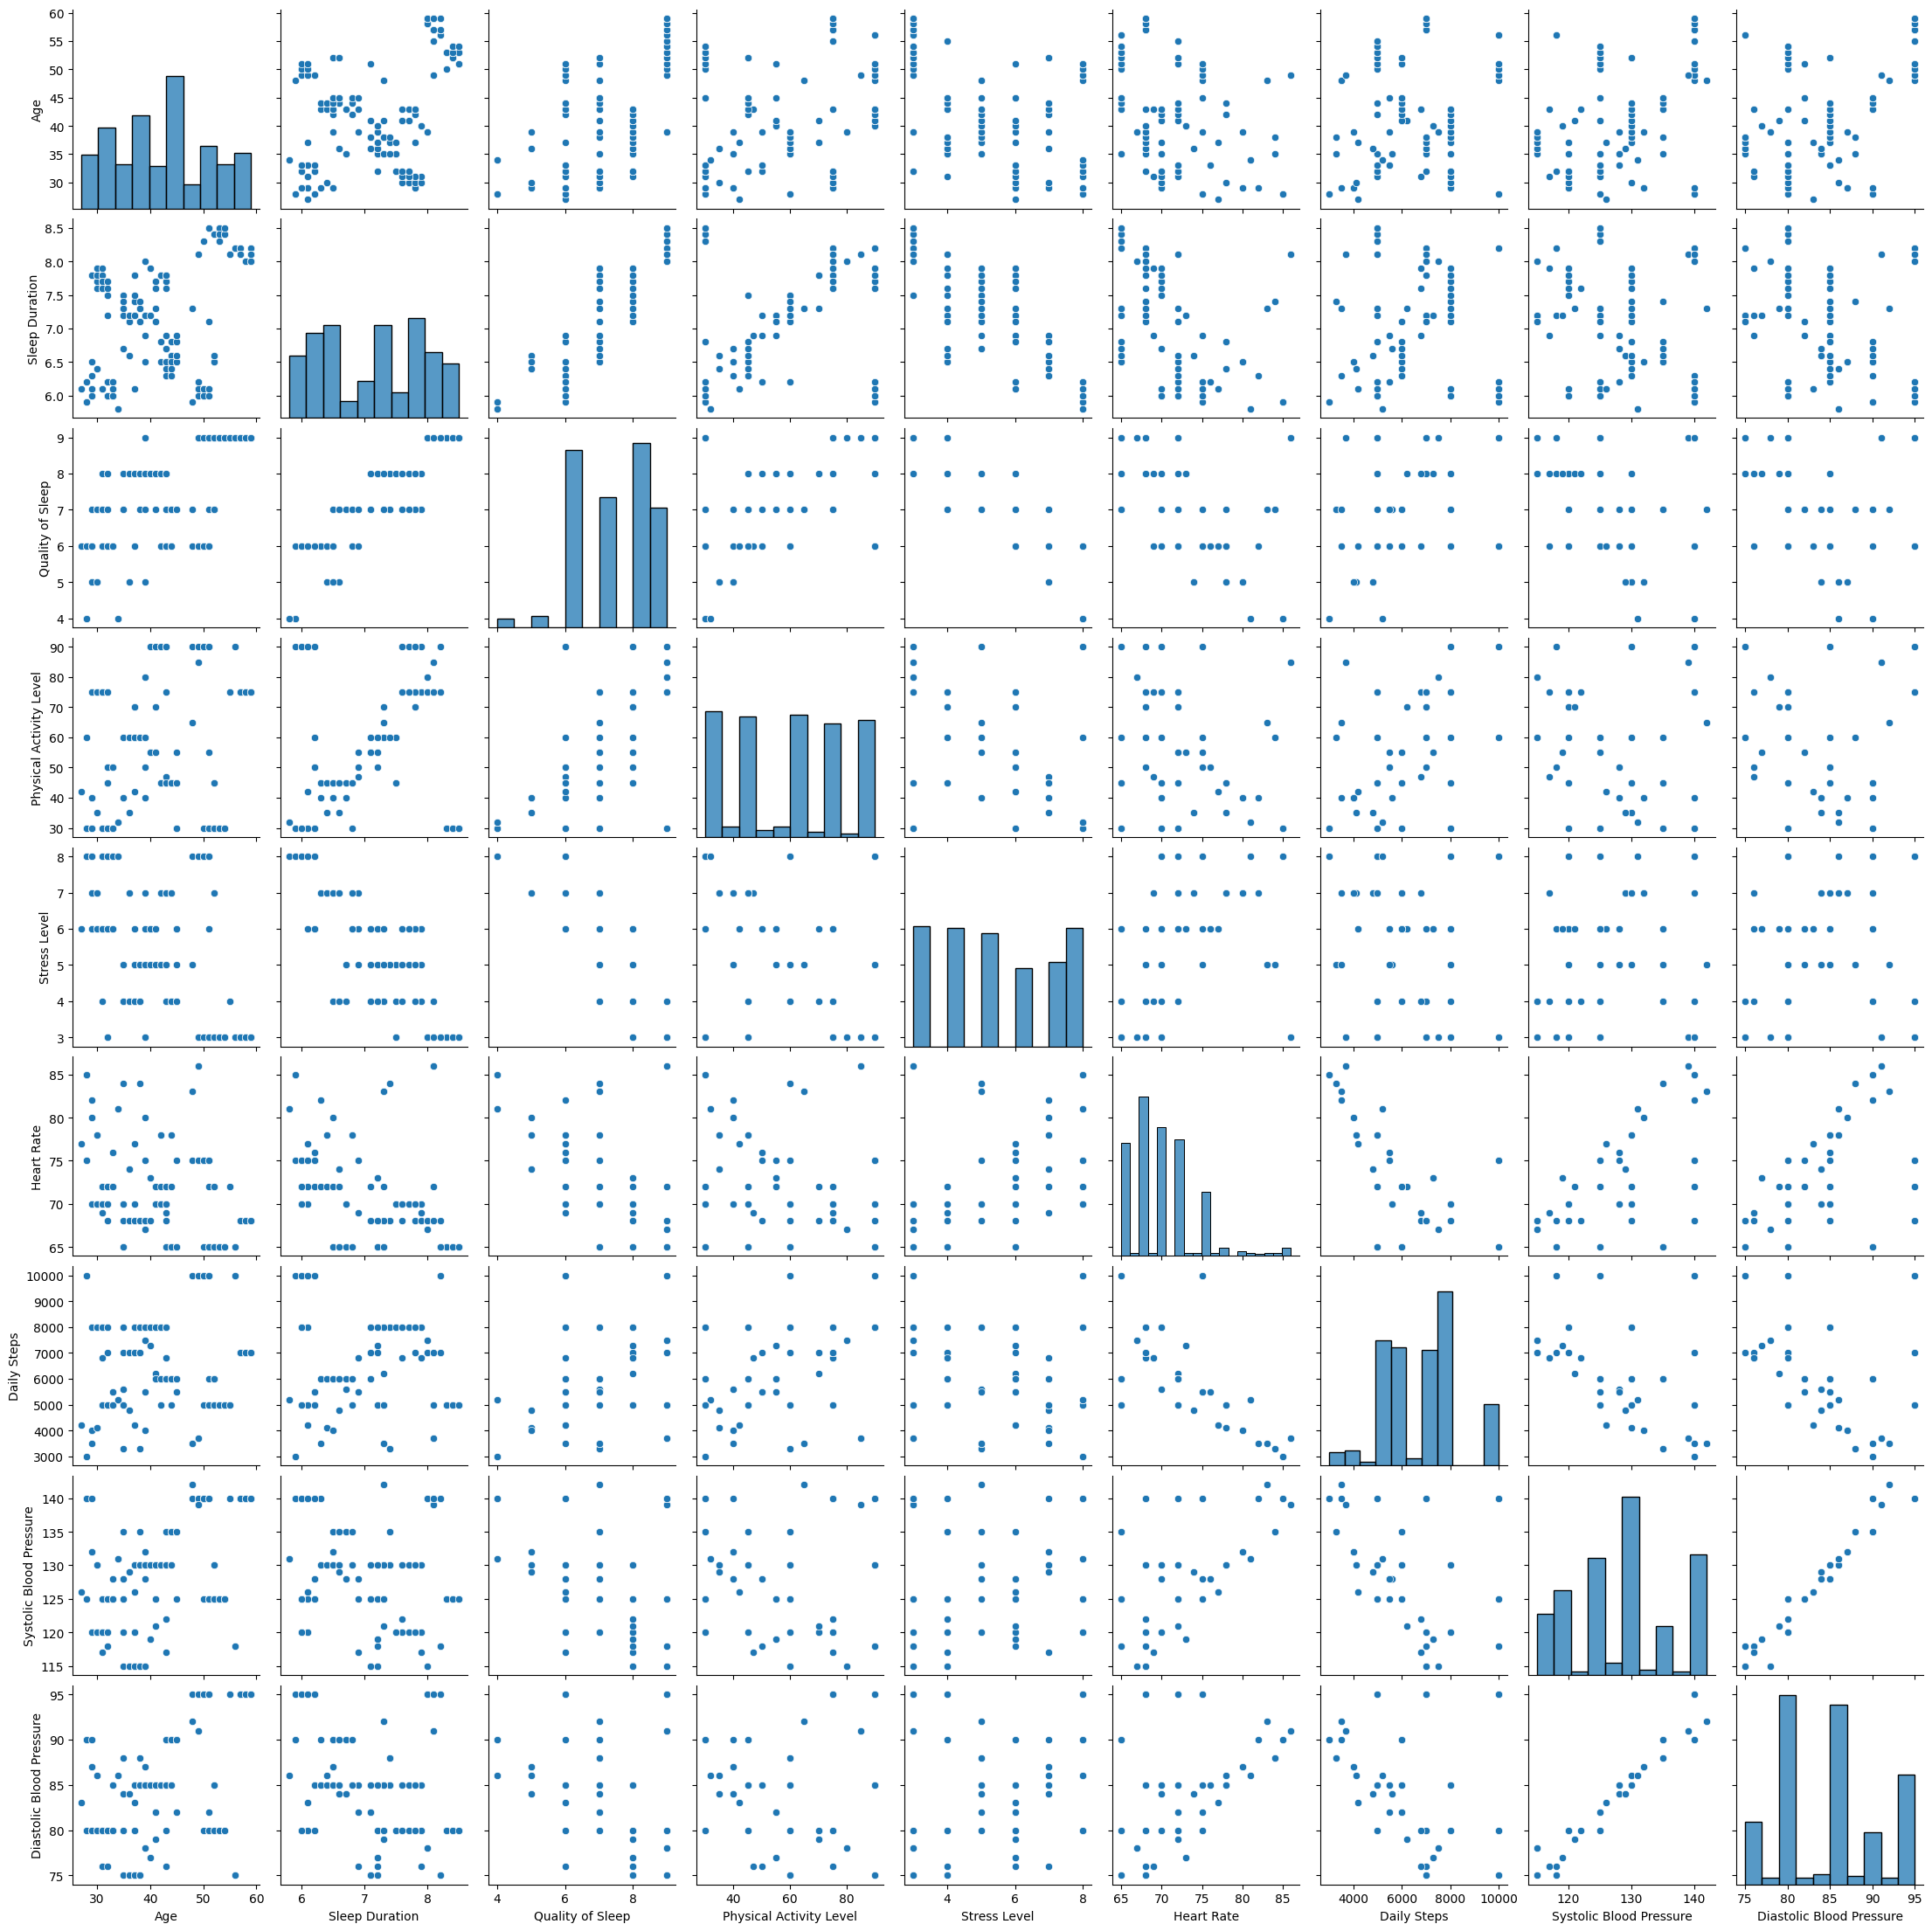

In [32]:
sns.pairplot(data=data)

This is a pairplot of the numerical features. The diagonal histograms show the distributions of the individual features and the scatterplots shows the pairwise combinations of the features. I see some positive associations of 'Quality of Sleep' with 'Sleep Duration' and 'Age'. There are negative associations between 'Stress Level' and 'Sleep Duration', 'Stress Level' and 'Quality of Sleep', and 'Daily Steps' and 'Heart Rate'. 'Systolic Blood Pressure' and 'Diastolic Blood Pressure' are obviously positively correlated to each other.

### <a id="step3">Correlation Matrix</a>
<a href="#contents">^ Contents</a>

Let's explore the features more by looking at the correlation matrix. I will one-hot encode the categorical features and use the drop='first' parameter to drop the first category of each categorical feature during one-hot encoding. This is done to avoid multicollinearity issues in linear models. When one-hot encoding is applied without dropping one of the categories, it creates one binary feature for each category. However, including all binary features can lead to multicollinearity, where the features become highly correlated. This can cause instability in models like linear regression. By dropping the first category, you effectively reduce redundancy in the encoded features. The dropped category becomes the reference category, and the presence or absence of the other categories is encoded in the remaining features. This approach maintains the information while avoiding multicollinearity.

In [36]:
class CorrelationMatrixGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        numerical_features = X[['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic Blood Pressure', 'Diastolic Blood Pressure']]
        categorical_features = X[['Gender', 'Occupation', 'BMI Category']]
        target_feature = X[['Sleep Disorder']]
        
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoded_categorical_features = encoder.fit_transform(categorical_features)
        encoded_categorical_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(categorical_features.columns))

        label_encoder = LabelEncoder()
        encoded_target = label_encoder.fit_transform(target_feature)
        encoded_target_df = pd.DataFrame(encoded_target, columns=['Sleep Disorder'])
        
        encoded_data = pd.concat([numerical_features, encoded_categorical_df, encoded_target_df], axis=1)
        correlation_matrix = encoded_data.corr()
        
        return correlation_matrix

C:\Users\lkim8\Anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


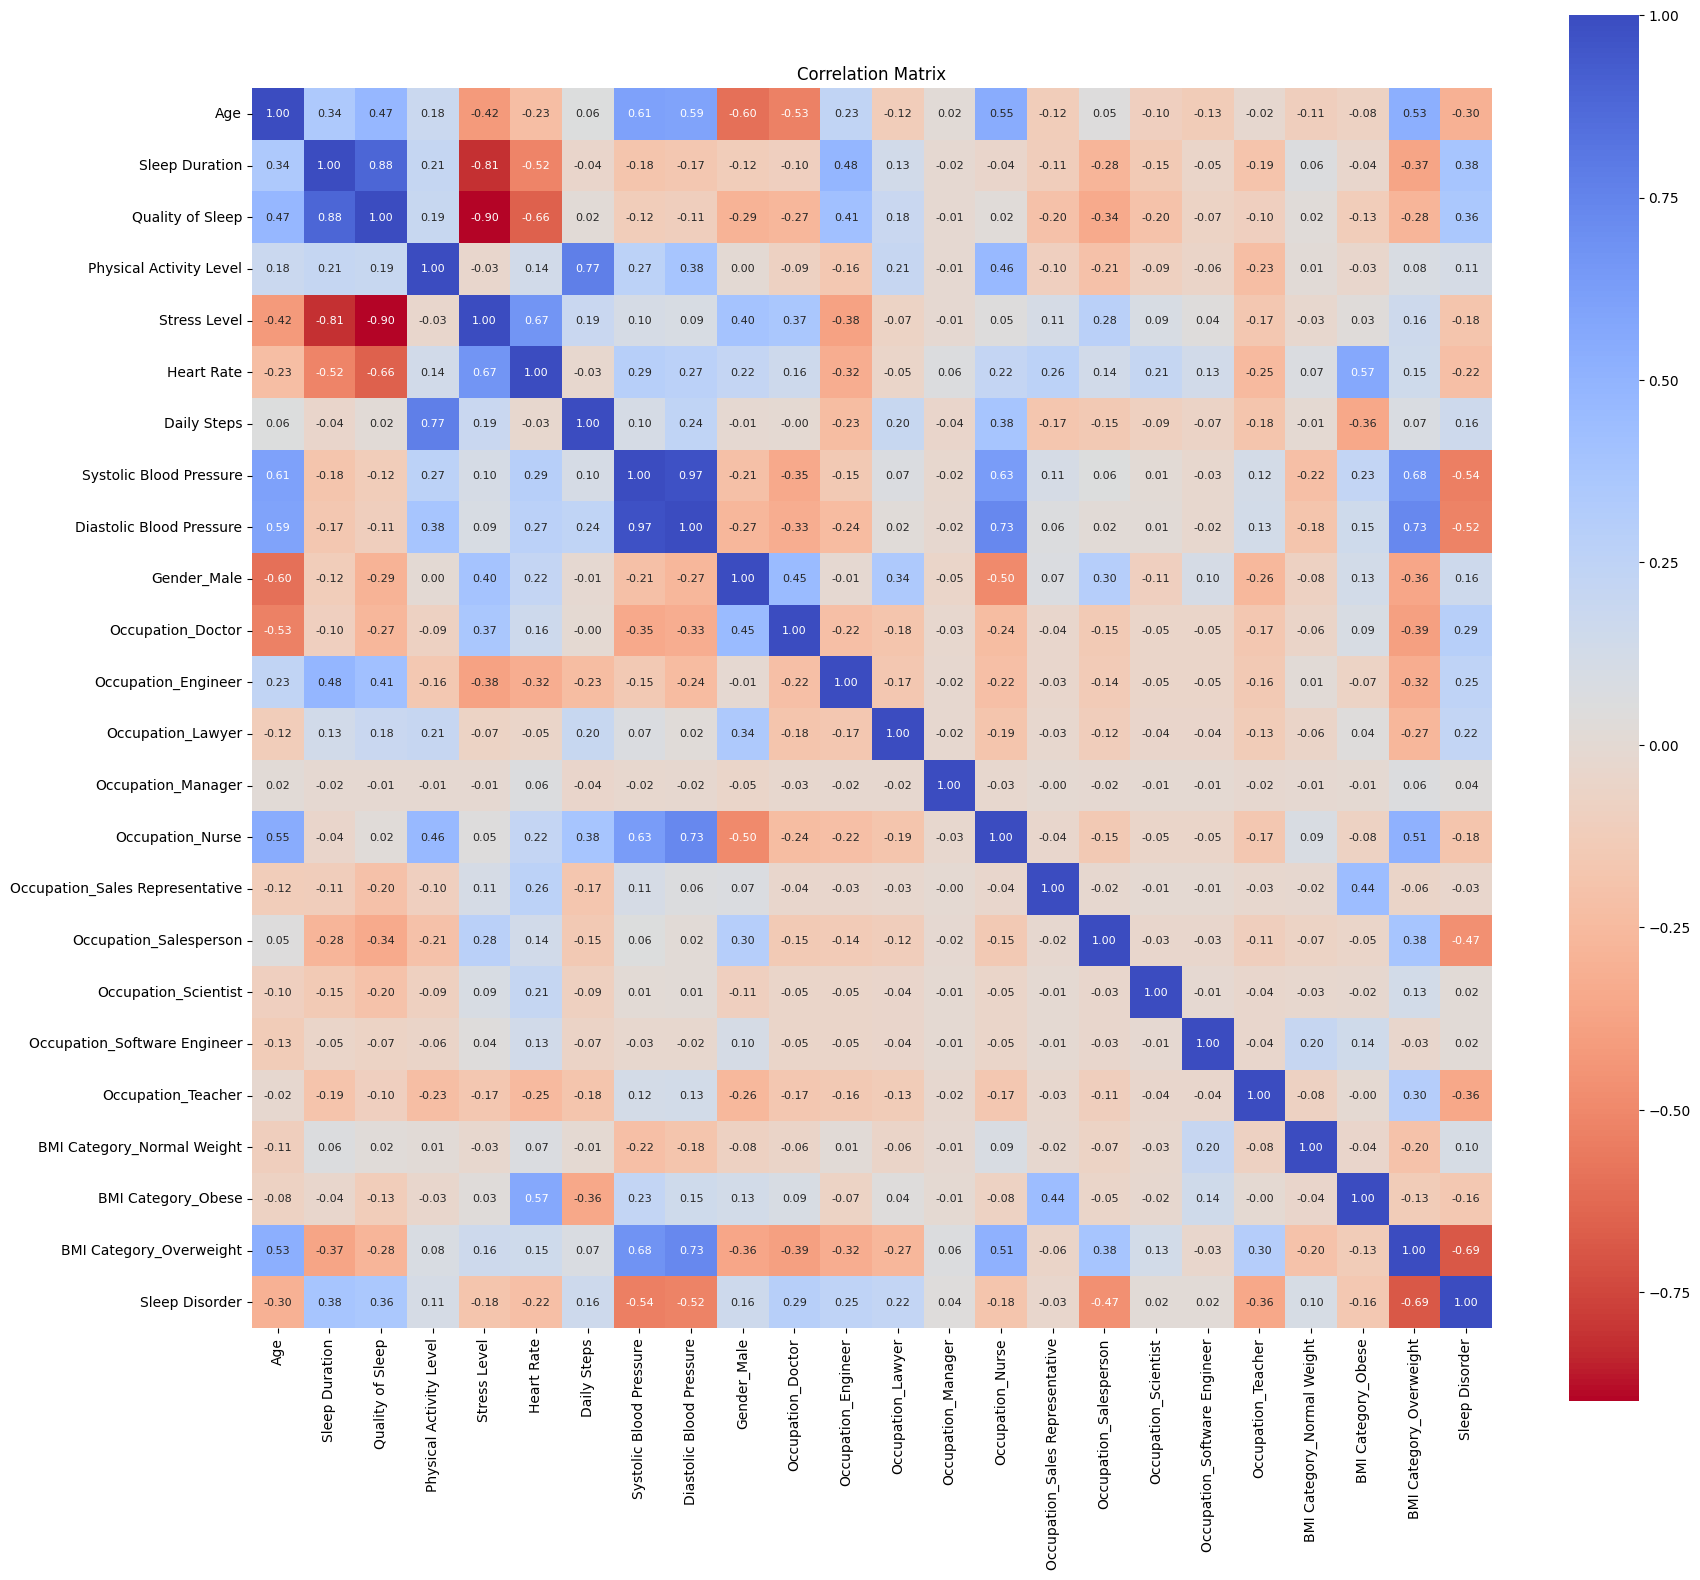

In [37]:
#data = df.copy()

# Create a pipeline with the correlation matrix generator
correlation_pipeline = Pipeline([('correlation_matrix_generator', CorrelationMatrixGenerator())])

# Fit the pipeline on your data
correlation_matrix = correlation_pipeline.fit_transform(data)

# Display the correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm_r', fmt=".2f", square=True, annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

To classify the correlation, I will use these ratings for the correlation coefficients:
- r < 0.16 = very weak
- r < 0.29 = weak
- r < 0.49 = low
- r < 0.69 = moderate
- r < 0.89 = strong
- r > 0.89 = very strong<br>

There is a strong positive relationship between 'Quality of Sleep' and 'Sleep Duration' with a correlation coefficient of 0.88. 'Sleep Duration' has a strong negative relationship with 'Stress Level' with a correlation coefficient of -0.81. 'Stress Level' and 'Quality of Sleep' has a very strong negative relationship with a correlation coefficient of -0.90. All of these three pairs of relationships are expected since we saw it in the pairplots from earlier. 'Daily Steps' and 'Physical Activity Level' have a strong positive relationship with a correlation coefficient of 0.77. Also, 'BMI Category_Overweight' has a strong negative relationship with the target variable, 'Sleep Disorder', with -0.69 correlation coefficient. 'BMI Category_Overweight' also have strong positive relationships with 'Systolic Blood Pressure' and 'Diastolic Blood Pressure', with 0.68 and 0.73 correlation coefficient respectively.

## <a id="step4">Feature Engineering</a>
<a href="#contents">^ Contents</a>

### <a id="step5">Column Encoding</a>
<a href="#contents">^ Contents</a>

Convert binary features to 0 and 1:

In [42]:
data2 = data.copy()
data2['Gender'] = data2['Gender'].map({'Male': 0, 'Female': 1})
data2['Sleep Disorder'] = data2['Sleep Disorder'].map({'Sleep Apnea': 0, 'Insomnia': 1})

Label encode the occupation column:

In [44]:
label_encoder = LabelEncoder()
data2['Occupation'] = label_encoder.fit_transform(data2['Occupation'])

Ordinal encode the BMI category column:

In [46]:
ordinal_encoder = OrdinalEncoder()
data2['BMI Category'] = ordinal_encoder.fit_transform(data2[['BMI Category']])

In [47]:
data

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic Blood Pressure,Diastolic Blood Pressure
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,140,95
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95


In [48]:
data2

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic Blood Pressure,Diastolic Blood Pressure
0,0,27,9,6.1,6,42,6,3.0,77,4200,NaN,126,83
1,0,28,1,6.2,6,60,8,0.0,75,10000,NaN,125,80
2,0,28,1,6.2,6,60,8,0.0,75,10000,NaN,125,80
3,0,28,6,5.9,4,30,8,2.0,85,3000,0.0,140,90
4,0,28,6,5.9,4,30,8,2.0,85,3000,0.0,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1,59,5,8.1,9,75,3,3.0,68,7000,0.0,140,95
370,1,59,5,8.0,9,75,3,3.0,68,7000,0.0,140,95
371,1,59,5,8.1,9,75,3,3.0,68,7000,0.0,140,95
372,1,59,5,8.1,9,75,3,3.0,68,7000,0.0,140,95


### <a id="step6">Random Forest Imputation</a>
<a href="#contents">^ Contents</a>

The target variable has 219 missing values, which is more than half of the observations of the dataset. I will be imputing and predicting the missing values with random forest classifier.

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder

def impute_missing_values(df, columns_to_fill, features_for_prediction):
    rf_classifier = RandomForestClassifier(random_state=123)
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    
    predicted_subset = df[features_for_prediction] # Use specified features for prediction
    inverse_transformed_subset = df[features_for_prediction]
    
    for column in columns_to_fill:
        subset = pd.concat([predicted_subset, df[column]], axis=1)
        
        # Split the dataset into one with missing values and one without missing values
        subset_with_missing = subset[subset[column].isnull()] # rows with missing values
        subset_without_missing = subset.dropna() # rows without missing values
        
        # Identify features and target variable
        X = subset_without_missing.drop(columns=[column])
        y = subset_without_missing[column]
        
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
        
        # Perform 5-fold cross-validation to train the classifier
        for train_index, _ in kf.split(X_train): # '_' to ignore test indices
            X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
            rf_classifier.fit(X_train_fold, y_train_fold)
        
        # Predict missing values using the trained classifier
        missing_X = subset_with_missing.drop(columns=[column])
        predicted_values = rf_classifier.predict(missing_X)
        
        # Fill in the missing values in the original DataFrame
        subset_with_missing[column] = predicted_values
        
        # Concatenate the DataFrame with missing values filled in with the DataFrame without missing values
        df_filled = pd.concat([subset_without_missing, subset_with_missing]).sort_index()
        
        # Update predicted_subset with predicted values
        predicted_subset[column] = df_filled[column]

        # Fit the ordinal encoder on the original column to obtain the mapping between encoded values and original categories
        original_data_column = pd.DataFrame([df[column].dropna()]).T
        ordinal_encoder.fit(original_data_column)
 
        # Inverse transform the predicted values and the values from the subset without missing back to their original categories
        predicted_values_original = ordinal_encoder.inverse_transform(predicted_values.reshape(-1, 1)).flatten()
        subset_without_missing_original = ordinal_encoder.inverse_transform(subset_without_missing[column].values.reshape(-1, 1)).flatten()
        
        # Add the inverse transformed values to the inv_trf_dataset 
        inverse_transformed_subset[column] = subset_without_missing_original.tolist() + predicted_values_original.tolist()
    
    return predicted_subset, inverse_transformed_subset

imputed_encoded_df, inv_trf_df = impute_missing_values(data2, ['Sleep Disorder'], ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Systolic Blood Pressure', 'Diastolic Blood Pressure'])
print('imputed encoded df:')
display(imputed_encoded_df)
print('not encoded data:')
display(data)

imputed encoded df:


C:\Users\lkim8\AppData\Local\Temp\ipykernel_13540\2067261528.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_with_missing[column] = predicted_values


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Systolic Blood Pressure,Diastolic Blood Pressure,Sleep Disorder
0,0,27,9,6.1,6,42,6,3.0,77,4200,126,83,1.0
1,0,28,1,6.2,6,60,8,0.0,75,10000,125,80,0.0
2,0,28,1,6.2,6,60,8,0.0,75,10000,125,80,0.0
3,0,28,6,5.9,4,30,8,2.0,85,3000,140,90,0.0
4,0,28,6,5.9,4,30,8,2.0,85,3000,140,90,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1,59,5,8.1,9,75,3,3.0,68,7000,140,95,0.0
370,1,59,5,8.0,9,75,3,3.0,68,7000,140,95,0.0
371,1,59,5,8.1,9,75,3,3.0,68,7000,140,95,0.0
372,1,59,5,8.1,9,75,3,3.0,68,7000,140,95,0.0


not encoded data:


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic Blood Pressure,Diastolic Blood Pressure
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,140,95
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95


Now let's look at the correlation matrix after the imputation:

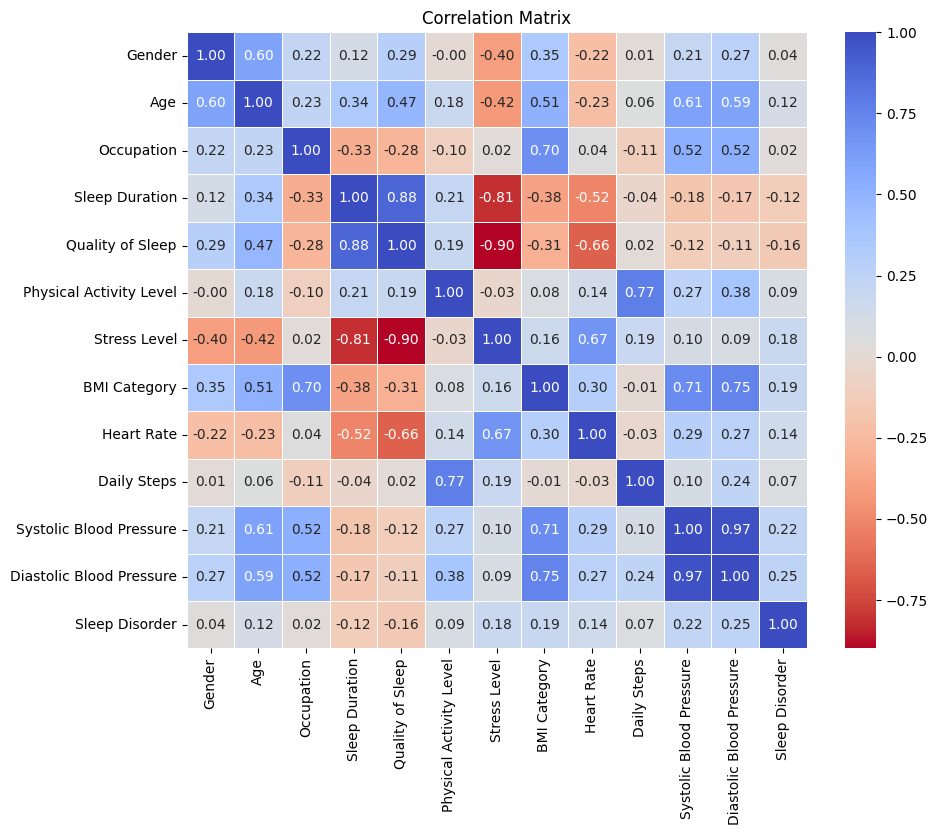

In [53]:
# Calculating the correlation matrix
correlation_matrix = inv_trf_df.corr()

# Plotting the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm_r', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The imputation of the target variables did not change any of the significant correlation coefficients found in the earlier correlation matrix. 

## <a id="step7">Supervised Learning</a>
<a href="#contents">^ Contents</a>

The three supervised learning classifiers that I will be using to develop the prediction models are Support Vector Machine (SVM), Extreme Gradient Boosting (XGBoost), and Random Forest Classifiers. First, I will use the one hot encoder for both training and testing variables. Since I will be splitting the training dataset for training, validation, and testing sets I will split the dataset with 50/10/40 train-validation-test split instead of the 40/10/50 split so that I have more observations for training. After splitting the dataset, I will use the X_train set to normalize, fit and transform the training set, then apply the same transformation on the X_val and X_test sets. This prevents data leakage from the validation or testing sets into the training process. This helps to provide reliable estimates of the models' performance on unseen data. For the validation and testing datasets, I will measure accuracy, precision, recall and F1 scores. After the analysis of the 50/10/40 split, I will also test the training, validation, and testing performances on 60/10/30, 70/10/20, and 80/10/10 splits. I will be comparing which train/validation/test split gives the best performances of the models.

In [57]:
final_df = data.copy()
final_df['Sleep Disorder'] = imputed_encoded_df['Sleep Disorder']
# final_df['Sleep Disorder'] = final_df['Sleep Disorder'].map({0: 'Sleep Apnea', 1: 'Insomnia'})
final_df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic Blood Pressure,Diastolic Blood Pressure
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,1.0,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,0.0,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,0.0,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,0.0,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,0.0,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,0.0,140,95
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,0.0,140,95
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,0.0,140,95
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,0.0,140,95


In [58]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Gender', 'Occupation', 'BMI Category']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit & transform the encoder on the categorical columns
encoded_columns = encoder.fit_transform(final_df[categorical_columns])

# Convert the encoded columns to a DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded DataFrame with the original DataFrame
final_df = pd.concat([final_df, encoded_df], axis=1)

# Drop the original categorical columns if needed
final_df.drop(categorical_columns, axis=1, inplace=True)

display(final_df.head())

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Sleep Disorder,Systolic Blood Pressure,Diastolic Blood Pressure,...,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight
0,27,6.1,6,42,6,77,4200,1.0,126,83,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,28,6.2,6,60,8,75,10000,0.0,125,80,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28,6.2,6,60,8,75,10000,0.0,125,80,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,28,5.9,4,30,8,85,3000,0.0,140,90,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,28,5.9,4,30,8,85,3000,0.0,140,90,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### <a id="step8">Hyperparameter Optimization</a>
<a href="#contents">^ Contents</a>

With each classifer, GridSearchCV will be used to find the optimal hyperparameters. I will use 10-fold cross-validation spliting and accuracy scoring strategy to evaluate the performance of the model on the test set. For the SVM, I will have three parameters (C, kernel, and gamma) for hyperparameter tuning. For the XGBoost, I will have four parameters (number of estimators, maximum depth, learning rate, and alpha regularization [L1]) for hyperparameter tuning. For the Random Forest, I will have four parameters (number of estimators, maximum depth, minimum samples split, and minimum samples leaf) for hyperparameter tuning. Once the optimal hyperparameters are found, I will define the models with their respective hyperparameters and perform a 10-fold cross validation. The mean accuracies and standard deviations will be calculated for the training analysis.

In [61]:
X = final_df.drop(columns=['Sleep Disorder'])
y = final_df['Sleep Disorder']

#### <a id="step9">Support Vector Machine Classifier</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (224, 26), y_train_val shape: (224,)
X_test shape: (150, 26), y_test shape: (150,)
X_train shape: (186, 26), y_train shape: (186,)
X_val shape: (38, 26), y_val shape: (38,)
Best Parameters for SVM: {'svm__C': 0.001, 'svm__gamma': 10, 'svm__kernel': 'poly'}
Best Score for SVM: 0.9304093567251461


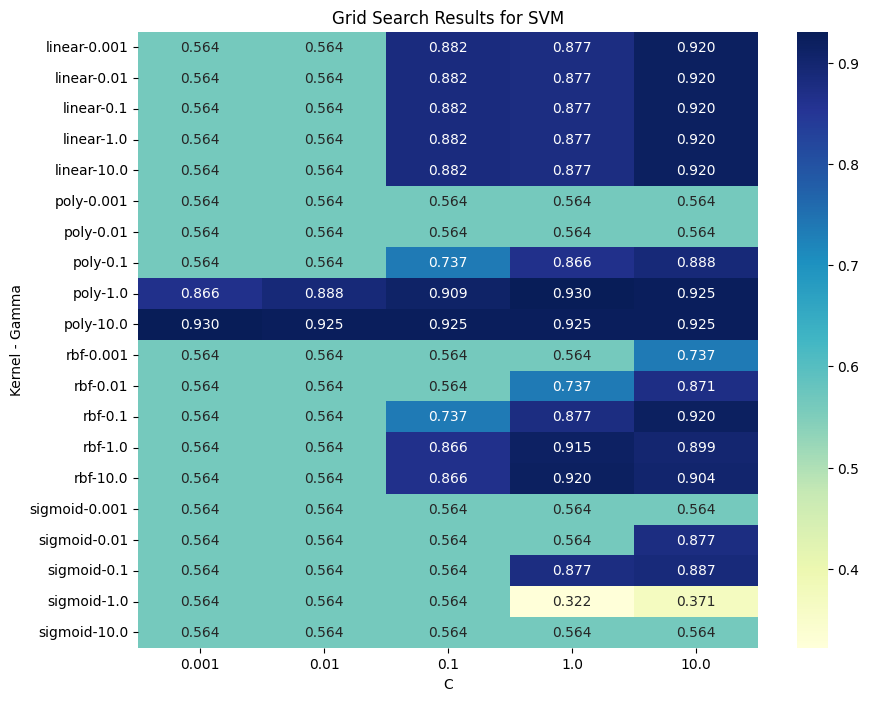

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Define the function for SVM with train/val/test splits
def svm_grid_search_with_splits(X, y, test_size, val_size, random_state=123):
    """
    This function splits the data into train, validation, and test sets,
    normalizes it, and performs GridSearchCV for an SVM model.
    
    Parameters:
    - X: DataFrame of features
    - y: Series of target variable
    - test_size: proportion of the test set
    - val_size: proportion of the validation set relative to the train set
    - random_state: random state for reproducibility
    
    Returns:
    - Best parameters for the SVM model
    - Grid search results heatmap
    """
    
    # Split data into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)
    
    # Split train+val into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=random_state, shuffle=True)

    # Print the shapes of the splits
    print(f'X_train_val shape: {X_train_val.shape}, y_train_val shape: {y_train_val.shape}')
    print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
    print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')

    # Apply MinMaxScaler normalization
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Define SVM pipeline
    svm_pipeline = Pipeline([('svm', SVC(random_state=random_state))])

    # Define parameter grids for hyperparameter tuning
    svm_param_grid = {
        'svm__C': [0.001, 0.01, 0.1, 1, 10],
        'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'svm__gamma': [0.001, 0.01, 0.1, 1, 10]}

    # Perform grid search for SVM
    svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=10, scoring='accuracy')
    svm_grid_search.fit(X_train_scaled, y_train)

    # Print best parameters and best score for SVM
    print("Best Parameters for SVM:", svm_grid_search.best_params_)
    print("Best Score for SVM:", svm_grid_search.best_score_)

    # Extract grid search results for SVM
    svm_results = pd.DataFrame(svm_grid_search.cv_results_)

    # Pivot the DataFrame to create a heatmap
    svm_heatmap_data = svm_results.pivot_table(index=['param_svm__kernel', 'param_svm__gamma'], columns='param_svm__C', values='mean_test_score', aggfunc='mean')

    # Plot heatmap for SVM
    plt.figure(figsize=(10, 8))
    sns.heatmap(svm_heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f", cbar=True)
    plt.title('Grid Search Results for SVM')
    plt.xlabel('C')
    plt.ylabel('Kernel - Gamma')
    plt.show()

    # Return the various split sets
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = svm_grid_search_with_splits(X, y, test_size=0.4, val_size=0.1)

# For a 60/10/30 split
# svm_grid_search_with_splits(X, y, test_size=0.3, val_size=0.1)

# For a 70/10/20 split
# svm_grid_search_with_splits(X, y, test_size=0.2, val_size=0.1)

# # For an 80/10/10 split
# svm_grid_search_with_splits(X, y, test_size=0.1, val_size=0.1)

In [67]:
from sklearn.model_selection import cross_val_score

# Define the models with their respective hyperparameters
svm_model = SVC(C=0.001, gamma=10, kernel='poly', random_state=123)

# Perform 10-fold cross-validation for SVM
svm_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("RBF SVM Cross-Validated Scores:")
print("SVM Mean Accuracy:", svm_scores.mean())
print("SVM Standard Deviation:", svm_scores.std())

RBF SVM Cross-Validated Scores:
SVM Mean Accuracy: 0.9304093567251461
SVM Standard Deviation: 0.05813936150473248


#### <a id="step10">XGBoost Classifier</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (224, 26), y_train_val shape: (224,)
X_test shape: (150, 26), y_test shape: (150,)
X_train shape: (186, 26), y_train shape: (186,)
X_val shape: (38, 26), y_val shape: (38,)
Best Parameters for XGBoost: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.01}
Best Score for XGBoost: 0.952046783625731


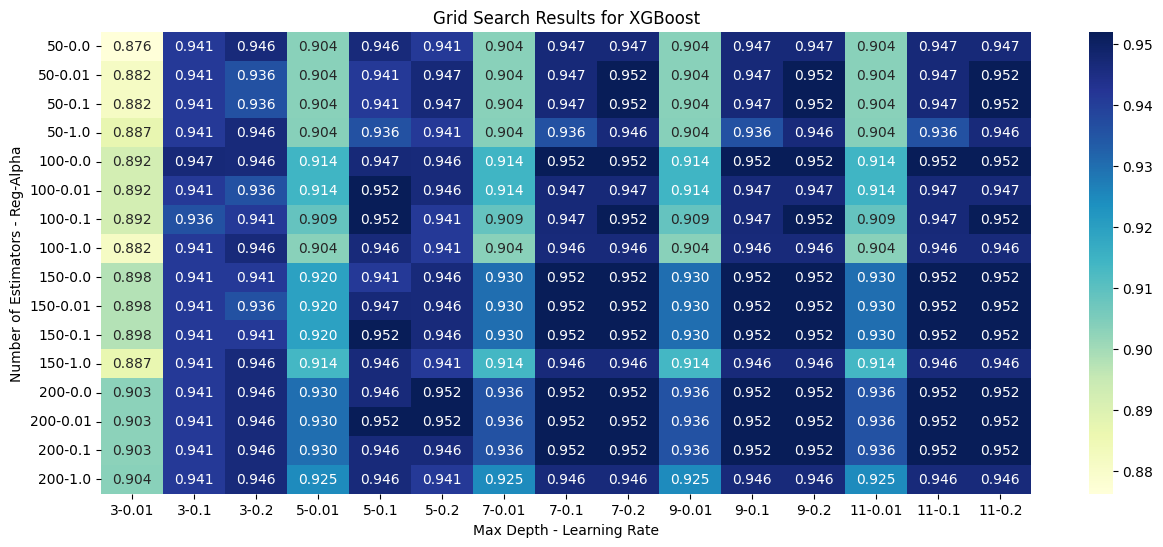

In [69]:
from xgboost import XGBClassifier

def xgb_grid_search_with_splits(X, y, test_size, val_size, random_state=123):
    """
    This function splits the data into train, validation, and test sets,
    normalizes it, and performs GridSearchCV for an XGBoost model.
    
    Parameters:
    - X: DataFrame of features
    - y: Series of target variable
    - test_size: proportion of the test set
    - val_size: proportion of the validation set relative to the train set
    - random_state: random state for reproducibility
    
    Returns:
    - Best parameters for the XGBoost model
    - Grid search results heatmap
    """
    
    # Split data into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)
    
    # Split train+val into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=random_state, shuffle=True)

    # Print the shapes of the splits
    print(f'X_train_val shape: {X_train_val.shape}, y_train_val shape: {y_train_val.shape}')
    print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
    print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')

    # Apply MinMaxScaler normalization
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Define XGBoost pipeline
    xgb_pipeline = Pipeline([('xgb', XGBClassifier(random_state=123))])
    
    # Define parameter grids for hyperparameter tuning
    xgb_param_grid = {
        'xgb__n_estimators': [50, 100, 150, 200],
        'xgb__max_depth': [3, 5, 7, 9, 11],
        'xgb__learning_rate': [0.01, 0.1, 0.2],
        'xgb__reg_alpha': [0, 0.01, 0.1, 1]}
    
    # Perform grid search for XGBoost
    xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=10, scoring='accuracy')
    xgb_grid_search.fit(X_train_scaled, y_train)
    
    # Print best parameters and best score for XGBoost
    print("Best Parameters for XGBoost:", xgb_grid_search.best_params_)
    print("Best Score for XGBoost:", xgb_grid_search.best_score_)
    
    # Extract grid search results for XGBoost
    xgb_results = pd.DataFrame(xgb_grid_search.cv_results_)
    
    # Pivot the DataFrame to create a heatmap
    xgb_heatmap_data = xgb_results.pivot_table(index=['param_xgb__n_estimators', 'param_xgb__reg_alpha'], columns=['param_xgb__max_depth', 'param_xgb__learning_rate'], values='mean_test_score', aggfunc='mean')
    
    # Plot heatmap for XGBoost
    plt.figure(figsize=(15, 6))
    sns.heatmap(xgb_heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f", cbar=True)
    plt.title('Grid Search Results for XGBoost')
    plt.xlabel('Max Depth - Learning Rate')
    plt.ylabel('Number of Estimators - Reg-Alpha')
    plt.show()
    
    # Return the various split sets
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = xgb_grid_search_with_splits(X, y, test_size=0.4, val_size=0.1)

In [71]:
# Define the models with their respective hyperparameters
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, random_state=123)

# Perform 10-fold cross-validation for XGBoost
xgb_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("XGBoost Cross-Validated Scores:")
print("Mean Accuracy:", xgb_scores.mean())
print("Standard Deviation:", xgb_scores.std())

XGBoost Cross-Validated Scores:
Mean Accuracy: 0.952046783625731
Standard Deviation: 0.049728237890754146


#### <a id="step11">Random Forest Classifier</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (224, 26), y_train_val shape: (224,)
X_test shape: (150, 26), y_test shape: (150,)
X_train shape: (186, 26), y_train shape: (186,)
X_val shape: (38, 26), y_val shape: (38,)
Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameter for random forest: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best score for random forest: 0.9517543859649124


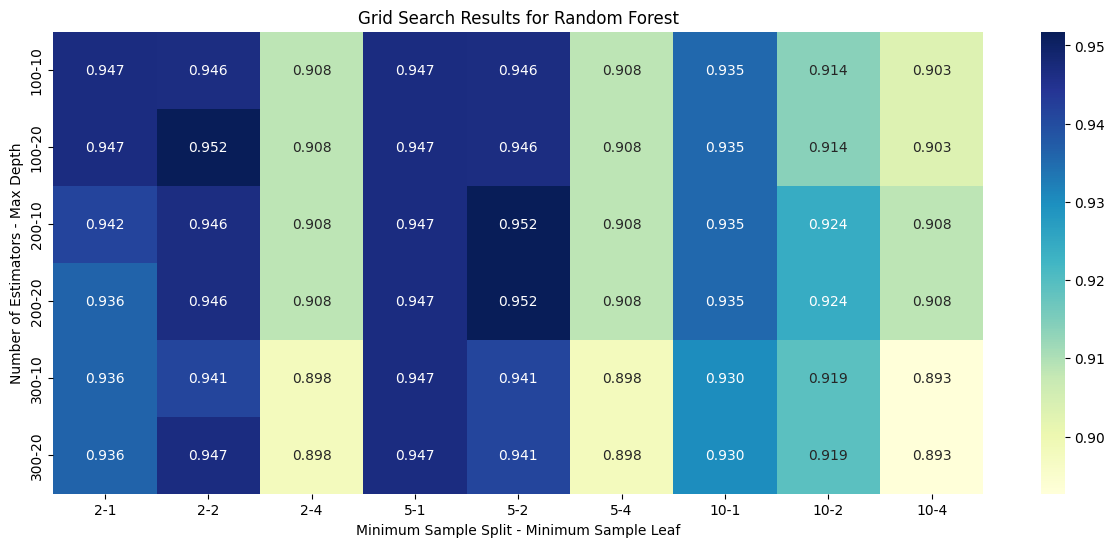

In [73]:
from sklearn.ensemble import RandomForestClassifier

def rf_grid_search_with_splits(X, y, test_size, val_size, random_state=123):
    """
    This function splits the data into train, validation, and test sets,
    normalizes it, and performs GridSearchCV for an Random Forest model.
    
    Parameters:
    - X: DataFrame of features
    - y: Series of target variable
    - test_size: proportion of the test set
    - val_size: proportion of the validation set relative to the train set
    - random_state: random state for reproducibility
    
    Returns:
    - Best parameters for the Random Forest model
    - Grid search results heatmap
    """
    
    # Split data into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)
    
    # Split train+val into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=random_state, shuffle=True)

    # Print the shapes of the splits
    print(f'X_train_val shape: {X_train_val.shape}, y_train_val shape: {y_train_val.shape}')
    print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
    print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')

    # Apply MinMaxScaler normalization
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Define the random forest pipeline
    rf_pipeline = Pipeline([('rf', RandomForestClassifier(criterion='gini', random_state=123))])
    
    # Define the parameter grid
    param_grid = {
        'rf__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'rf__max_depth': [None, 10, 20],       # Maximum depth of the trees
        'rf__min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
        'rf__min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
    }
    
    # Instantiate GridSearchCV with the pipeline
    rf_grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
    
    # Fit the GridSearchCV
    rf_grid_search.fit(X_train_scaled, y_train)
    
    # Get the best parameters and best score
    best_params = rf_grid_search.best_params_
    best_score = rf_grid_search.best_score_
    print(f'Best parameter for random forest: {best_params}')
    print(f'Best score for random forest: {best_score}')
    
    # Extract grid search results for Random Forest
    rf_results = pd.DataFrame(rf_grid_search.cv_results_)
    
    # Pivot the DataFrame to create a heatmap
    rf_heatmap_data = rf_results.pivot_table(index=['param_rf__n_estimators', 'param_rf__max_depth'], columns=['param_rf__min_samples_split', 'param_rf__min_samples_leaf'], values='mean_test_score', aggfunc='mean')
    
    # Plot heatmap for Random Forest
    plt.figure(figsize=(15, 6))
    sns.heatmap(rf_heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f", cbar=True)
    plt.title('Grid Search Results for Random Forest')
    plt.xlabel('Minimum Sample Split - Minimum Sample Leaf')
    plt.ylabel('Number of Estimators - Max Depth')
    plt.show()

    # Return the various split sets
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = rf_grid_search_with_splits(X, y, test_size=0.4, val_size=0.1)

In [75]:
# Define the models with their respective hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=123)

# Perform 10-fold cross-validation for XGBoost
rf_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("Random Forest Cross-Validated Scores:")
print("Mean Accuracy:", rf_scores.mean())
print("Standard Deviation:", rf_scores.std())

Random Forest Cross-Validated Scores:
Mean Accuracy: 0.9517543859649124
Standard Deviation: 0.049763470495872555


In [77]:
from tabulate import tabulate

train_accuracies = [['SVM',  svm_scores.mean(), svm_scores.std()],
                    ['XGBoost',  xgb_scores.mean(), xgb_scores.std()],
                    ['Random Forest',  rf_scores.mean(), rf_scores.std()]]

train_table = tabulate(train_accuracies, headers=["Model 1 (50/10/40)", "Training Accuracy", "Training Standard Deviation"], tablefmt="grid", floatfmt=".4f")

print(train_table)

+----------------------+---------------------+-------------------------------+
| Model 1 (50/10/40)   |   Training Accuracy |   Training Standard Deviation |
+======================+=====================+===============================+
| SVM                  |              0.9304 |                        0.0581 |
+----------------------+---------------------+-------------------------------+
| XGBoost              |              0.9520 |                        0.0497 |
+----------------------+---------------------+-------------------------------+
| Random Forest        |              0.9518 |                        0.0498 |
+----------------------+---------------------+-------------------------------+


XGBoost training accuracy of 95.20% was the highest, but Random Forest classifers had very similar training accuracy of 95.18%. Their training standard deviations were very similar, 0.0497 and 0.0498 for XGBoost and Random Forest respectively. SVM training accuracy was slightly lower with 93.04% with slightly higher standard deviation of 0.0581.

## <a id="step12">Model Performance Evaluation</a>
<a href="#contents">^ Contents</a>

The three classification models will be evaluated for their performances by fitting the training set and predicting with the validation set first and then the testing set. Four scoring metrics accuracy, precision, recall and F1 will be used for analysis.
- Accuracy: overall measurement of how often the model predicts the correct label
- Precision: measures the proportion of positive predictions that are actually correct
- Recall: measures the proportion of actual positives that were correctly identified
- F1: weighed average of precision and recall 

### <a id="step13">Validation Performance</a>
<a href="#contents">^ Contents</a>

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the models with the best hyperparameters
svm_model = SVC(C=0.001, gamma=10, kernel='poly', random_state=123)

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = svm_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
svm_accuracy = accuracy_score(y_val, y_pred)
svm_precision = precision_score(y_val, y_pred)
svm_recall = recall_score(y_val, y_pred)
svm_f1 = f1_score(y_val, y_pred)

print("SVM Accuracy on the validation set: {:.4f}".format(svm_accuracy))
print("SVM Precision on the validation set: {:.4f}".format(svm_precision))
print("SVM Recall on the validation set: {:.4f}".format(svm_recall))
print("SVM F1 on the validation set: {:.4f}".format(svm_f1))

SVM Accuracy on the validation set: 0.8947
SVM Precision on the validation set: 0.8696
SVM Recall on the validation set: 0.9524
SVM F1 on the validation set: 0.9091


In [82]:
# Define the models with the best hyperparameters
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, random_state=123)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = xgb_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
xgb_accuracy = accuracy_score(y_val, y_pred)
xgb_precision = precision_score(y_val, y_pred)
xgb_recall = recall_score(y_val, y_pred)
xgb_f1 = f1_score(y_val, y_pred)

print("XGBoost Accuracy on the validation set: {:.4f}".format(xgb_accuracy))
print("XGBoost Precision on the validation set: {:.4f}".format(xgb_precision))
print("XGBoost Recall on the validation set: {:.4f}".format(xgb_recall))
print("XGBoost F1 on the validation set: {:.4f}".format(xgb_f1))

XGBoost Accuracy on the validation set: 0.9211
XGBoost Precision on the validation set: 0.9091
XGBoost Recall on the validation set: 0.9524
XGBoost F1 on the validation set: 0.9302


In [84]:
# Define the model with the best hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=123)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = rf_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
rf_accuracy = accuracy_score(y_val, y_pred)
rf_precision = precision_score(y_val, y_pred)
rf_recall = recall_score(y_val, y_pred)
rf_f1 = f1_score(y_val, y_pred)

print("Random Forest Accuracy on the validation set: {:.4f}".format(rf_accuracy))
print("Random Forest Precision on the validation set: {:.4f}".format(rf_precision))
print("Random Forest Recall on the validation set: {:.4f}".format(rf_recall))
print("Random Forest F1 on the validation set: {:.4f}".format(rf_f1))

Random Forest Accuracy on the validation set: 0.9474
Random Forest Precision on the validation set: 0.9524
Random Forest Recall on the validation set: 0.9524
Random Forest F1 on the validation set: 0.9524


In [86]:
validation_accuracies = [['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1],
         ['XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
         ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1]]

validation_table = tabulate(validation_accuracies, headers=["Model 1 (50/10/40)", "Validation Accuracy", 'Validation Precision', 'Validation Recall', 'Validation F1'], tablefmt="grid", floatfmt=".4f")

print(validation_table)

+----------------------+-----------------------+------------------------+---------------------+-----------------+
| Model 1 (50/10/40)   |   Validation Accuracy |   Validation Precision |   Validation Recall |   Validation F1 |
+======================+=======================+========================+=====================+=================+
| SVM                  |                0.8947 |                 0.8696 |              0.9524 |          0.9091 |
+----------------------+-----------------------+------------------------+---------------------+-----------------+
| XGBoost              |                0.9211 |                 0.9091 |              0.9524 |          0.9302 |
+----------------------+-----------------------+------------------------+---------------------+-----------------+
| Random Forest        |                0.9474 |                 0.9524 |              0.9524 |          0.9524 |
+----------------------+-----------------------+------------------------+---------------

Random Forest classifier has the highest validation accuracy of 94.74%, followed by XGBoost with 92.11% and SVM with 89.47% accuracies. Random Forest classifier also had the highest precision and F1 scores of 95.24%, followed by XGBoost with the second highest precision of 90.91% and F1 score of 93.02%. SVM only falls slightly lower than XGBoost for both precision and F1 as well. All three classifers had the same recall score of 95.24%. 

Now let's use the testing set:

### <a id="step14">Test Performance</a>
<a href="#contents">^ Contents</a>

In [88]:
# Define the models with the best hyperparameters
svm_model = SVC(C=0.001, gamma=10, kernel='poly', random_state=123)

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = svm_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

print("SVM Accuracy on the testing set: {:.4f}".format(svm_accuracy))
print("SVM Precision on the testing set: {:.4f}".format(svm_precision))
print("SVM Recall on the testing set: {:.4f}".format(svm_recall))
print("SVM F1 on the testing set: {:.4f}".format(svm_f1))

SVM Accuracy on the testing set: 0.9600
SVM Precision on the testing set: 0.9451
SVM Recall on the testing set: 0.9885
SVM F1 on the testing set: 0.9663


In [90]:
# Define the models with the best hyperparameters
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, random_state=123)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = xgb_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)

print("XGBoost Accuracy on the testing set: {:.4f}".format(xgb_accuracy))
print("XGBoost Precision on the testing set: {:.4f}".format(xgb_precision))
print("XGBoost Recall on the testing set: {:.4f}".format(xgb_recall))
print("XGBoost F1 on the testing set: {:.4f}".format(xgb_f1))

XGBoost Accuracy on the testing set: 0.9467
XGBoost Precision on the testing set: 0.9759
XGBoost Recall on the testing set: 0.9310
XGBoost F1 on the testing set: 0.9529


In [92]:
# Define the model with the best hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=123)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = rf_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

print("Random Forest Accuracy on the testing set: {:.4f}".format(rf_accuracy))
print("Random Forest Precision on the testing set: {:.4f}".format(rf_precision))
print("Random Forest Recall on the testing set: {:.4f}".format(rf_recall))
print("Random Forest F1 on the testing set: {:.4f}".format(rf_f1))

Random Forest Accuracy on the testing set: 0.9600
Random Forest Precision on the testing set: 0.9880
Random Forest Recall on the testing set: 0.9425
Random Forest F1 on the testing set: 0.9647


In [94]:
testing_accuracies = [['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1],
         ['XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
         ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1]]

test_table = tabulate(testing_accuracies, headers=["Model 1 (50/10/40)", "Test Accuracy", "Test Precision", "Test Recall", "Test F1"], tablefmt="grid", floatfmt=".4f")

print(test_table)

+----------------------+-----------------+------------------+---------------+-----------+
| Model 1 (50/10/40)   |   Test Accuracy |   Test Precision |   Test Recall |   Test F1 |
+======================+=================+==================+===============+===========+
| SVM                  |          0.9600 |           0.9451 |        0.9885 |    0.9663 |
+----------------------+-----------------+------------------+---------------+-----------+
| XGBoost              |          0.9467 |           0.9759 |        0.9310 |    0.9529 |
+----------------------+-----------------+------------------+---------------+-----------+
| Random Forest        |          0.9600 |           0.9880 |        0.9425 |    0.9647 |
+----------------------+-----------------+------------------+---------------+-----------+


SVM and Random Forest classifiers has the highest accuracy of 96%. Random Forest classifier has the highest precision score of 98.8% while SVM has the highest recall and F1 scores of 98.85% and 96.63% respectively.

### <a id="step15">Performance Evaluation Across Multiple Train/Validation/Test Splits</a>
<a href="#contents">^ Contents</a>

Let's explore the various balance of train/validation/test splits with 60/10/30, 70/10/20, and 80/10/10 splits to see which percentages gives the best performance of the classifiers.

#### <a id="step16">Model 2: 60/10/30 split</a>
<a href="#contents">^ Contents</a>

##### <a id="step17">SVM Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (261, 26), y_train_val shape: (261,)
X_test shape: (113, 26), y_test shape: (113,)
X_train shape: (223, 26), y_train shape: (223,)
X_val shape: (38, 26), y_val shape: (38,)
Best Parameters for SVM: {'svm__C': 0.001, 'svm__gamma': 10, 'svm__kernel': 'poly'}
Best Score for SVM: 0.9464426877470358


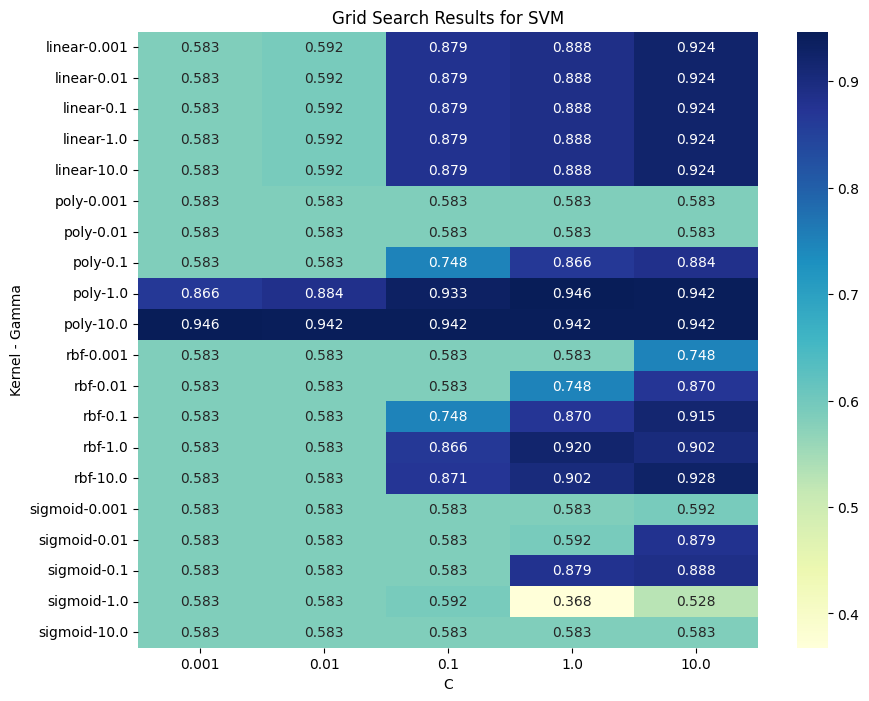

In [117]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = svm_grid_search_with_splits(X, y, test_size=0.3, val_size=0.1)

In [120]:
# Define the models with their respective hyperparameters
svm_model = SVC(C=0.001, gamma=10, kernel='poly', random_state=123)

# Perform 10-fold cross-validation for SVM
svm_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("RBF SVM Cross-Validated Scores:")
print("SVM Mean Accuracy:", svm_scores.mean())
print("SVM Standard Deviation:", svm_scores.std())

RBF SVM Cross-Validated Scores:
SVM Mean Accuracy: 0.9464426877470358
SVM Standard Deviation: 0.03325153873707967


##### <a id="step18">XGBoost Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (261, 26), y_train_val shape: (261,)
X_test shape: (113, 26), y_test shape: (113,)
X_train shape: (223, 26), y_train shape: (223,)
X_val shape: (38, 26), y_val shape: (38,)
Best Parameters for XGBoost: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 150, 'xgb__reg_alpha': 0.1}
Best Score for XGBoost: 0.9598814229249013


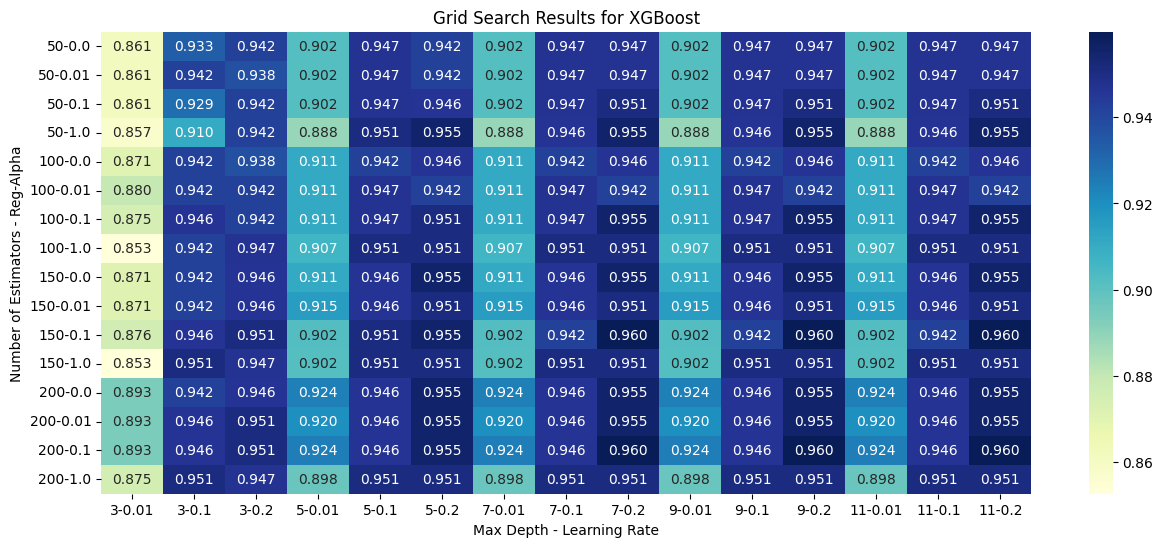

In [123]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = xgb_grid_search_with_splits(X, y, test_size=0.3, val_size=0.1)

In [127]:
# Define the models with their respective hyperparameters
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, random_state=123)

# Perform 10-fold cross-validation for XGBoost
xgb_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("XGBoost Cross-Validated Scores:")
print("Mean Accuracy:", xgb_scores.mean())
print("Standard Deviation:", xgb_scores.std())

XGBoost Cross-Validated Scores:
Mean Accuracy: 0.9598814229249013
Standard Deviation: 0.031160812989234947


##### <a id="step19">Random Forest Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (261, 26), y_train_val shape: (261,)
X_test shape: (113, 26), y_test shape: (113,)
X_train shape: (223, 26), y_train shape: (223,)
X_val shape: (38, 26), y_val shape: (38,)
Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameter for random forest: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best score for random forest: 0.9644268774703558


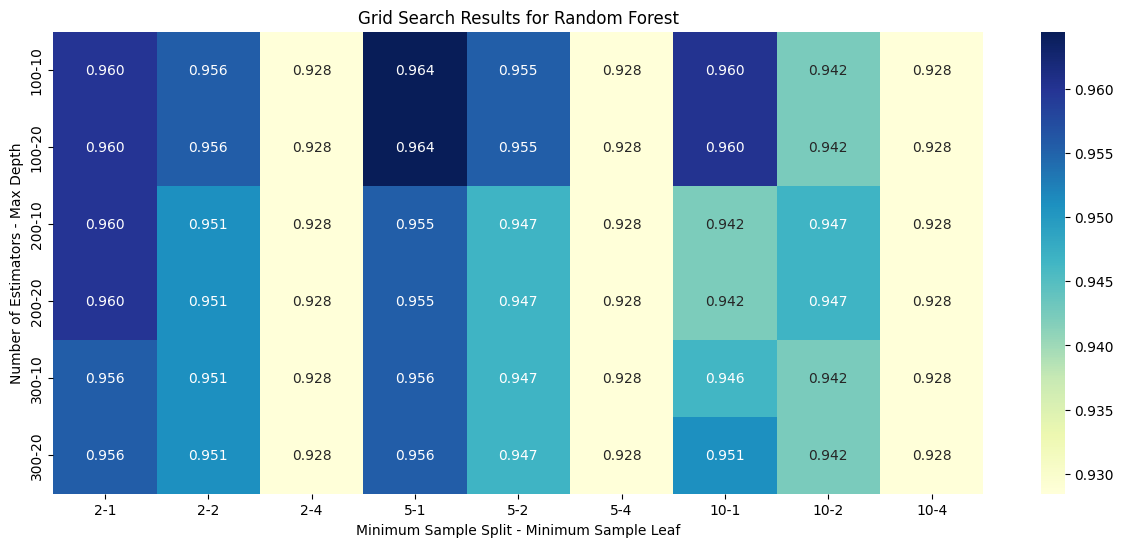

In [130]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = rf_grid_search_with_splits(X, y, test_size=0.3, val_size=0.1)

In [132]:
# Define the models with their respective hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=123)

# Perform 10-fold cross-validation for XGBoost
rf_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("Random Forest Cross-Validated Scores:")
print("Mean Accuracy:", rf_scores.mean())
print("Standard Deviation:", rf_scores.std())

Random Forest Cross-Validated Scores:
Mean Accuracy: 0.9644268774703558
Standard Deviation: 0.03329321065808612


###### <a id="step20">TRAINING RESULTS</a>
<a href="#contents">^ Contents</a>

In [161]:
train_accuracies = [['SVM',  svm_scores.mean(), svm_scores.std()],
                    ['XGBoost',  xgb_scores.mean(), xgb_scores.std()],
                    ['Random Forest',  rf_scores.mean(), rf_scores.std()]]

train_table2 = tabulate(train_accuracies, headers=["Model 2 (60/10/30)", "Training Accuracy", "Training Standard Deviation"], tablefmt="grid", floatfmt=".4f")

print(train_table)
print()
print(train_table2)

+----------------------+---------------------+-------------------------------+
| Model 1 (50/10/40)   |   Training Accuracy |   Training Standard Deviation |
+======================+=====================+===============================+
| SVM                  |              0.9304 |                        0.0581 |
+----------------------+---------------------+-------------------------------+
| XGBoost              |              0.9520 |                        0.0497 |
+----------------------+---------------------+-------------------------------+
| Random Forest        |              0.9518 |                        0.0498 |
+----------------------+---------------------+-------------------------------+

+----------------------+---------------------+-------------------------------+
| Model 2 (60/10/30)   |   Training Accuracy |   Training Standard Deviation |
+======================+=====================+===============================+
| SVM                  |              0.9464 |     

Model 2 with 60/10/30 split between training/validation/testing sets has slightly better training accuracies for all three models. All increased by about 1%. Standard deviations for model 2 is narrower than the model 1 standard deviations.

Now let's look at the validation accuracy, precision, recall, and F1 scores:

##### <a id="step21">SVM Validation</a>
<a href="#contents">^ Contents</a>

In [151]:
# Define the models with the best hyperparameters
svm_model = SVC(C=0.001, gamma=10, kernel='poly', random_state=123)

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = svm_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
svm_accuracy = accuracy_score(y_val, y_pred)
svm_precision = precision_score(y_val, y_pred)
svm_recall = recall_score(y_val, y_pred)
svm_f1 = f1_score(y_val, y_pred)

print("SVM Accuracy on the validation set: {:.4f}".format(svm_accuracy))
print("SVM Precision on the validation set: {:.4f}".format(svm_precision))
print("SVM Recall on the validation set: {:.4f}".format(svm_recall))
print("SVM F1 on the validation set: {:.4f}".format(svm_f1))

SVM Accuracy on the validation set: 0.9474
SVM Precision on the validation set: 0.9048
SVM Recall on the validation set: 1.0000
SVM F1 on the validation set: 0.9500


##### <a id="step22">XGBoost Validation</a>
<a href="#contents">^ Contents</a>

In [155]:
# Define the models with the best hyperparameters
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, random_state=123)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = xgb_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
xgb_accuracy = accuracy_score(y_val, y_pred)
xgb_precision = precision_score(y_val, y_pred)
xgb_recall = recall_score(y_val, y_pred)
xgb_f1 = f1_score(y_val, y_pred)

print("XGBoost Accuracy on the validation set: {:.4f}".format(xgb_accuracy))
print("XGBoost Precision on the validation set: {:.4f}".format(xgb_precision))
print("XGBoost Recall on the validation set: {:.4f}".format(xgb_recall))
print("XGBoost F1 on the validation set: {:.4f}".format(xgb_f1))

XGBoost Accuracy on the validation set: 0.9474
XGBoost Precision on the validation set: 0.9048
XGBoost Recall on the validation set: 1.0000
XGBoost F1 on the validation set: 0.9500


##### <a id="step23">Random Forest Validation</a>
<a href="#contents">^ Contents</a>

In [158]:
# Define the model with the best hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=123)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = rf_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
rf_accuracy = accuracy_score(y_val, y_pred)
rf_precision = precision_score(y_val, y_pred)
rf_recall = recall_score(y_val, y_pred)
rf_f1 = f1_score(y_val, y_pred)

print("Random Forest Accuracy on the validation set: {:.4f}".format(rf_accuracy))
print("Random Forest Precision on the validation set: {:.4f}".format(rf_precision))
print("Random Forest Recall on the validation set: {:.4f}".format(rf_recall))
print("Random Forest F1 on the validation set: {:.4f}".format(rf_f1))

Random Forest Accuracy on the validation set: 0.9474
Random Forest Precision on the validation set: 0.9048
Random Forest Recall on the validation set: 1.0000
Random Forest F1 on the validation set: 0.9500


###### <a id="step24">VALIDATION RESULTS</a>
<a href="#contents">^ Contents</a>

In [165]:
validation_accuracies = [['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1],
         ['XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
         ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1]]

validation_table2 = tabulate(validation_accuracies, headers=["Model 2 (60/10/30)", "Validation Accuracy", 'Validation Precision', 'Validation Recall', 'Validation F1'], tablefmt="grid", floatfmt=".4f")

print(validation_table)
print()
print(validation_table2)

+----------------------+-----------------------+------------------------+---------------------+-----------------+
| Model 1 (50/10/40)   |   Validation Accuracy |   Validation Precision |   Validation Recall |   Validation F1 |
+======================+=======================+========================+=====================+=================+
| SVM                  |                0.8947 |                 0.8696 |              0.9524 |          0.9091 |
+----------------------+-----------------------+------------------------+---------------------+-----------------+
| XGBoost              |                0.9211 |                 0.9091 |              0.9524 |          0.9302 |
+----------------------+-----------------------+------------------------+---------------------+-----------------+
| Random Forest        |                0.9474 |                 0.9524 |              0.9524 |          0.9524 |
+----------------------+-----------------------+------------------------+---------------

Model 2 gave the same accuracy, precision, recall, and F1 scores for all three classifiers, and its scores are better than model 1 scores. 

Now let's look at the accuracy, precision, recall, and F1 scores for the testing data:

##### <a id="step25">SVM Testing</a>
<a href="#contents">^ Contents</a>

In [171]:
# Define the models with the best hyperparameters
svm_model = SVC(C=0.001, gamma=10, kernel='poly', random_state=123)

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = svm_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

print("SVM Accuracy on the testing set: {:.4f}".format(svm_accuracy))
print("SVM Precision on the testing set: {:.4f}".format(svm_precision))
print("SVM Recall on the testing set: {:.4f}".format(svm_recall))
print("SVM F1 on the testing set: {:.4f}".format(svm_f1))

SVM Accuracy on the testing set: 0.9735
SVM Precision on the testing set: 0.9552
SVM Recall on the testing set: 1.0000
SVM F1 on the testing set: 0.9771


##### <a id="step26">XGBoost Testing</a>
<a href="#contents">^ Contents</a>

In [174]:
# Define the models with the best hyperparameters
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, reg_alpha=0.1, random_state=123)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = xgb_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)

print("XGBoost Accuracy on the testing set: {:.4f}".format(xgb_accuracy))
print("XGBoost Precision on the testing set: {:.4f}".format(xgb_precision))
print("XGBoost Recall on the testing set: {:.4f}".format(xgb_recall))
print("XGBoost F1 on the testing set: {:.4f}".format(xgb_f1))

XGBoost Accuracy on the testing set: 0.9469
XGBoost Precision on the testing set: 0.9833
XGBoost Recall on the testing set: 0.9219
XGBoost F1 on the testing set: 0.9516


##### <a id="step27">Random Forest Testing</a>
<a href="#contents">^ Contents</a>

In [177]:
# Define the model with the best hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=123)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = rf_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

print("Random Forest Accuracy on the testing set: {:.4f}".format(rf_accuracy))
print("Random Forest Precision on the testing set: {:.4f}".format(rf_precision))
print("Random Forest Recall on the testing set: {:.4f}".format(rf_recall))
print("Random Forest F1 on the testing set: {:.4f}".format(rf_f1))

Random Forest Accuracy on the testing set: 0.9469
Random Forest Precision on the testing set: 0.9833
Random Forest Recall on the testing set: 0.9219
Random Forest F1 on the testing set: 0.9516


###### <a id="step28">TESTING RESULTS</a>
<a href="#contents">^ Contents</a>

In [182]:
testing_accuracies = [['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1],
         ['XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
         ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1]]

test_table2 = tabulate(testing_accuracies, headers=["Model 2 (60/10/30)", "Test Accuracy", "Test Precision", "Test Recall", "Test F1"], tablefmt="grid", floatfmt=".4f")

print(test_table)
print()
print(test_table2)

+----------------------+-----------------+------------------+---------------+-----------+
| Model 1 (50/10/40)   |   Test Accuracy |   Test Precision |   Test Recall |   Test F1 |
+======================+=================+==================+===============+===========+
| SVM                  |          0.9600 |           0.9451 |        0.9885 |    0.9663 |
+----------------------+-----------------+------------------+---------------+-----------+
| XGBoost              |          0.9467 |           0.9759 |        0.9310 |    0.9529 |
+----------------------+-----------------+------------------+---------------+-----------+
| Random Forest        |          0.9600 |           0.9880 |        0.9425 |    0.9647 |
+----------------------+-----------------+------------------+---------------+-----------+

+----------------------+-----------------+------------------+---------------+-----------+
| Model 2 (60/10/30)   |   Test Accuracy |   Test Precision |   Test Recall |   Test F1 |
+========

In model 2 SVM has the highest accuracy, recall and F1 scores of 97.35%, 100%, and 97.71% respectively. Precision is slightly lower (95.52%) in comparison to the other models' precision score of 98.33%. XGBoost and Random Forest classifiers performed and have the same scores amongst each other. 

Now let's move onto model 3 and see how it performs:

#### <a id="step29">Model 3: 70/10/20 Split</a>
<a href="#contents">^ Contents</a>

##### <a id="step30">SVM Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (299, 26), y_train_val shape: (299,)
X_test shape: (75, 26), y_test shape: (75,)
X_train shape: (261, 26), y_train shape: (261,)
X_val shape: (38, 26), y_val shape: (38,)
Best Parameters for SVM: {'svm__C': 0.1, 'svm__gamma': 10, 'svm__kernel': 'poly'}
Best Score for SVM: 0.9464387464387464


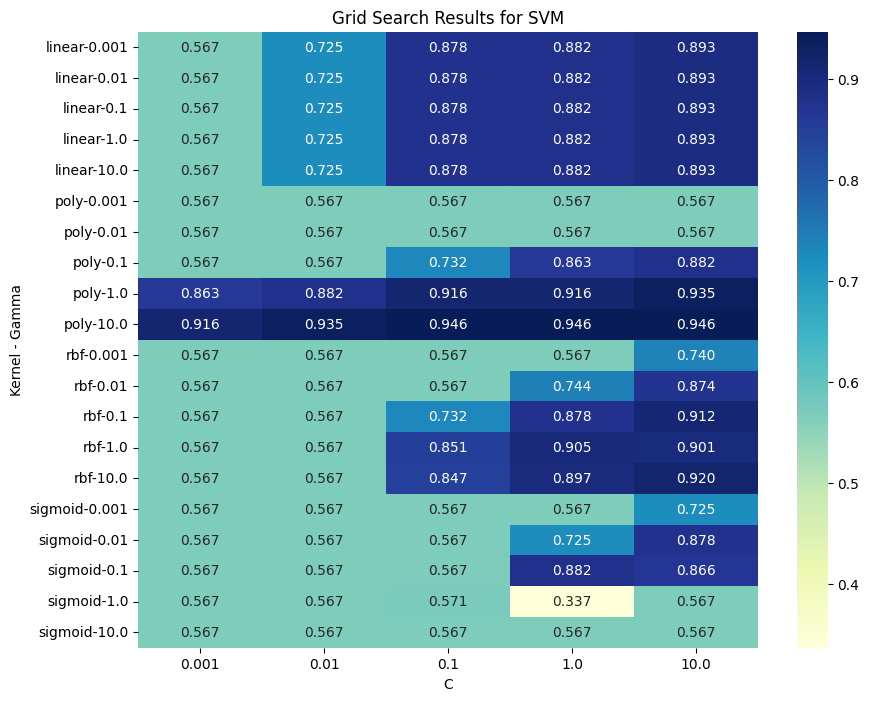

In [200]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = svm_grid_search_with_splits(X, y, test_size=0.2, val_size=0.1)

In [202]:
# Define the models with their respective hyperparameters
svm_model = SVC(C=0.1, gamma=10, kernel='poly', random_state=123)

# Perform 10-fold cross-validation for SVM
svm_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("RBF SVM Cross-Validated Scores:")
print("SVM Mean Accuracy:", svm_scores.mean())
print("SVM Standard Deviation:", svm_scores.std())

RBF SVM Cross-Validated Scores:
SVM Mean Accuracy: 0.9464387464387464
SVM Standard Deviation: 0.04268372987755137


##### <a id="step31">XGBoost Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (299, 26), y_train_val shape: (299,)
X_test shape: (75, 26), y_test shape: (75,)
X_train shape: (261, 26), y_train shape: (261,)
X_val shape: (38, 26), y_val shape: (38,)
Best Parameters for XGBoost: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 0.1}
Best Score for XGBoost: 0.9465811965811965


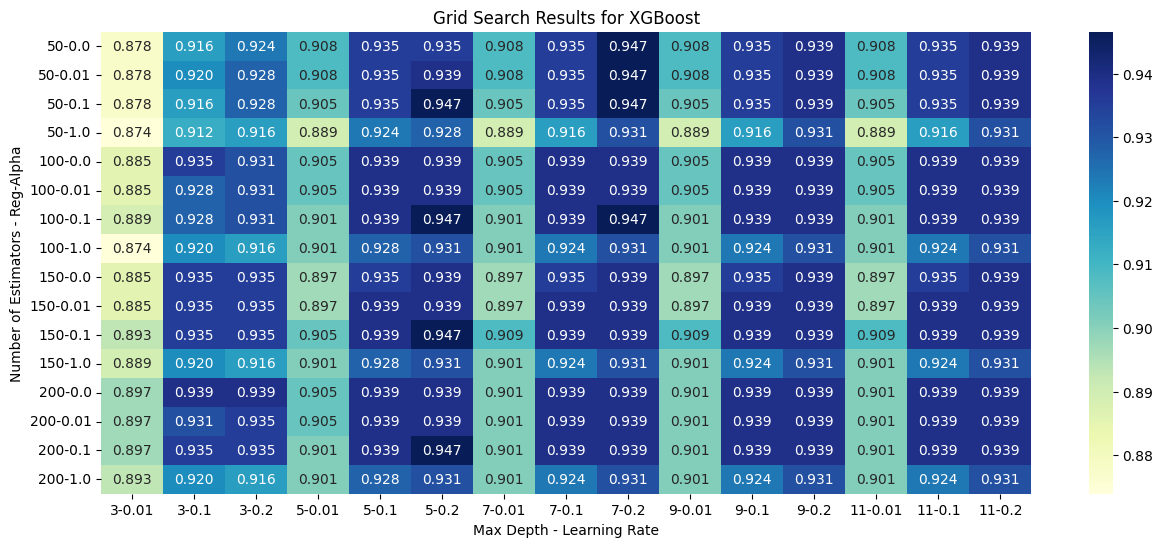

In [206]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = xgb_grid_search_with_splits(X, y, test_size=0.2, val_size=0.1)

In [208]:
# Define the models with their respective hyperparameters
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=50, reg_alpha=0.1, random_state=123)

# Perform 10-fold cross-validation for XGBoost
xgb_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("XGBoost Cross-Validated Scores:")
print("Mean Accuracy:", xgb_scores.mean())
print("Standard Deviation:", xgb_scores.std())

XGBoost Cross-Validated Scores:
Mean Accuracy: 0.9465811965811965
Standard Deviation: 0.045598510881483964


##### <a id="step32">Random Forest Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (299, 26), y_train_val shape: (299,)
X_test shape: (75, 26), y_test shape: (75,)
X_train shape: (261, 26), y_train shape: (261,)
X_val shape: (38, 26), y_val shape: (38,)
Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameter for random forest: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best score for random forest: 0.943019943019943


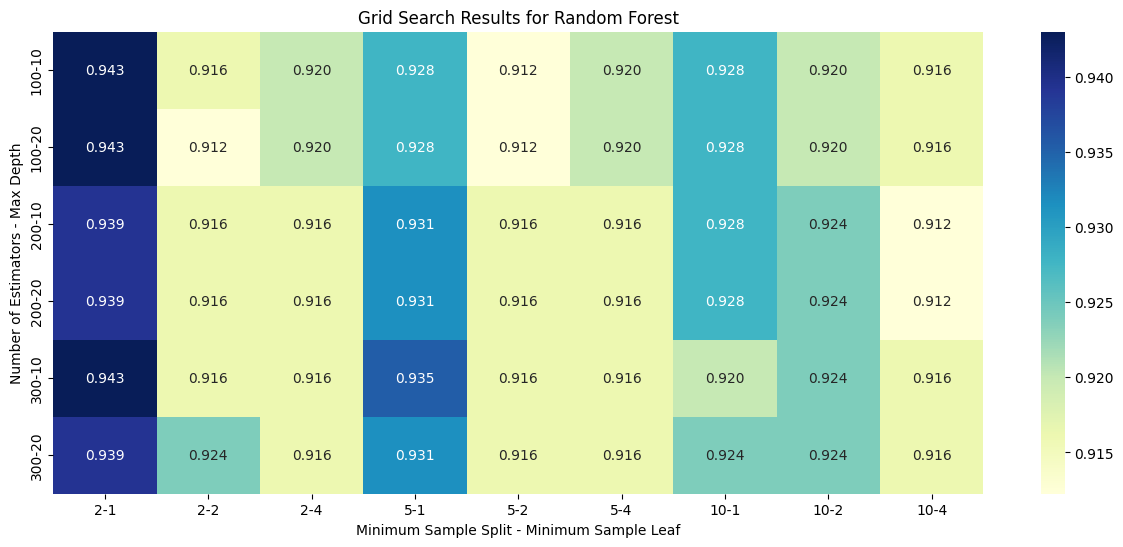

In [211]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = rf_grid_search_with_splits(X, y, test_size=0.2, val_size=0.1)

In [214]:
# Define the models with their respective hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123)

# Perform 10-fold cross-validation for XGBoost
rf_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("Random Forest Cross-Validated Scores:")
print("Mean Accuracy:", rf_scores.mean())
print("Standard Deviation:", rf_scores.std())

Random Forest Cross-Validated Scores:
Mean Accuracy: 0.943019943019943
Standard Deviation: 0.05604648311369233


###### <a id="step33">TRAINING RESULTS</a>
<a href="#contents">^ Contents</a>

In [216]:
train_accuracies = [['SVM',  svm_scores.mean(), svm_scores.std()],
                    ['XGBoost',  xgb_scores.mean(), xgb_scores.std()],
                    ['Random Forest',  rf_scores.mean(), rf_scores.std()]]

train_table3 = tabulate(train_accuracies, headers=["Model 3 (70/10/20)", "Training Accuracy", "Training Standard Deviation"], tablefmt="grid", floatfmt=".4f")

print(train_table)
print()
print(train_table2)
print()
print(train_table3)

+----------------------+---------------------+-------------------------------+
| Model 1 (50/10/40)   |   Training Accuracy |   Training Standard Deviation |
+======================+=====================+===============================+
| SVM                  |              0.9304 |                        0.0581 |
+----------------------+---------------------+-------------------------------+
| XGBoost              |              0.9520 |                        0.0497 |
+----------------------+---------------------+-------------------------------+
| Random Forest        |              0.9518 |                        0.0498 |
+----------------------+---------------------+-------------------------------+

+----------------------+---------------------+-------------------------------+
| Model 2 (60/10/30)   |   Training Accuracy |   Training Standard Deviation |
+======================+=====================+===============================+
| SVM                  |              0.9464 |     

In model 3, all three classifiers performed very similarly and have very similar training accuracy scores. The standard deviation for all three classifiers did increase by the hundredth in comparison to model 2.

Now let's look at the validation accuracy, precision, recall, and F1 scores of the model:

##### <a id="step34">SVM Validation</a>
<a href="#contents">^ Contents</a>

In [221]:
# Define the models with the best hyperparameters
svm_model = SVC(C=0.1, gamma=10, kernel='poly', random_state=123)

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = svm_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
svm_accuracy = accuracy_score(y_val, y_pred)
svm_precision = precision_score(y_val, y_pred)
svm_recall = recall_score(y_val, y_pred)
svm_f1 = f1_score(y_val, y_pred)

print("SVM Accuracy on the validation set: {:.4f}".format(svm_accuracy))
print("SVM Precision on the validation set: {:.4f}".format(svm_precision))
print("SVM Recall on the validation set: {:.4f}".format(svm_recall))
print("SVM F1 on the validation set: {:.4f}".format(svm_f1))

SVM Accuracy on the validation set: 0.9474
SVM Precision on the validation set: 0.9583
SVM Recall on the validation set: 0.9583
SVM F1 on the validation set: 0.9583


##### <a id="step35">XGBoost Validation</a>
<a href="#contents">^ Contents</a>

In [224]:
# Define the models with the best hyperparameters
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=50, reg_alpha=0.1, random_state=123)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = xgb_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
xgb_accuracy = accuracy_score(y_val, y_pred)
xgb_precision = precision_score(y_val, y_pred)
xgb_recall = recall_score(y_val, y_pred)
xgb_f1 = f1_score(y_val, y_pred)

print("XGBoost Accuracy on the validation set: {:.4f}".format(xgb_accuracy))
print("XGBoost Precision on the validation set: {:.4f}".format(xgb_precision))
print("XGBoost Recall on the validation set: {:.4f}".format(xgb_recall))
print("XGBoost F1 on the validation set: {:.4f}".format(xgb_f1))

XGBoost Accuracy on the validation set: 0.9211
XGBoost Precision on the validation set: 0.9200
XGBoost Recall on the validation set: 0.9583
XGBoost F1 on the validation set: 0.9388


##### <a id="step36">Random Forest Validation</a>
<a href="#contents">^ Contents</a>

In [227]:
# Define the model with the best hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = rf_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
rf_accuracy = accuracy_score(y_val, y_pred)
rf_precision = precision_score(y_val, y_pred)
rf_recall = recall_score(y_val, y_pred)
rf_f1 = f1_score(y_val, y_pred)

print("Random Forest Accuracy on the validation set: {:.4f}".format(rf_accuracy))
print("Random Forest Precision on the validation set: {:.4f}".format(rf_precision))
print("Random Forest Recall on the validation set: {:.4f}".format(rf_recall))
print("Random Forest F1 on the validation set: {:.4f}".format(rf_f1))

Random Forest Accuracy on the validation set: 0.9737
Random Forest Precision on the validation set: 0.9600
Random Forest Recall on the validation set: 1.0000
Random Forest F1 on the validation set: 0.9796


###### <a id="step37">VALIDATION RESULTS</a>
<a href="#contents">^ Contents</a>

In [232]:
validation_accuracies = [['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1],
         ['XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
         ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1]]

validation_table3 = tabulate(validation_accuracies, headers=["Model 3 (70/10/20)", "Validation Accuracy", 'Validation Precision', 'Validation Recall', 'Validation F1'], tablefmt="grid", floatfmt=".4f")

print(validation_table)
print()
print(validation_table2)
print()
print(validation_table3)

+----------------------+-----------------------+------------------------+---------------------+-----------------+
| Model 1 (50/10/40)   |   Validation Accuracy |   Validation Precision |   Validation Recall |   Validation F1 |
+======================+=======================+========================+=====================+=================+
| SVM                  |                0.8947 |                 0.8696 |              0.9524 |          0.9091 |
+----------------------+-----------------------+------------------------+---------------------+-----------------+
| XGBoost              |                0.9211 |                 0.9091 |              0.9524 |          0.9302 |
+----------------------+-----------------------+------------------------+---------------------+-----------------+
| Random Forest        |                0.9474 |                 0.9524 |              0.9524 |          0.9524 |
+----------------------+-----------------------+------------------------+---------------

In model 3, Random Forest classifier had the best accuracy, precision, recall, and F1 scores (97.37%, 96%, 100%, and 97.96%) in comparison to the XGBoost and SVM classifiers. The next best performance was seen with SVM. 

Now let's look at the accuracy, precision, recall, and F1 scores for the testing data:

##### <a id="step38">SVM Testing</a>
<a href="#contents">^ Contents</a>

In [237]:
# Define the models with the best hyperparameters
svm_model = SVC(C=0.1, gamma=10, kernel='poly', random_state=123)

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = svm_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

print("SVM Accuracy on the testing set: {:.4f}".format(svm_accuracy))
print("SVM Precision on the testing set: {:.4f}".format(svm_precision))
print("SVM Recall on the testing set: {:.4f}".format(svm_recall))
print("SVM F1 on the testing set: {:.4f}".format(svm_f1))

SVM Accuracy on the testing set: 0.9733
SVM Precision on the testing set: 1.0000
SVM Recall on the testing set: 0.9512
SVM F1 on the testing set: 0.9750


##### <a id="step39">XGBoost Testing</a>
<a href="#contents">^ Contents</a>

In [240]:
# Define the models with the best hyperparameters
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=50, reg_alpha=0.1, random_state=123)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = xgb_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)

print("XGBoost Accuracy on the testing set: {:.4f}".format(xgb_accuracy))
print("XGBoost Precision on the testing set: {:.4f}".format(xgb_precision))
print("XGBoost Recall on the testing set: {:.4f}".format(xgb_recall))
print("XGBoost F1 on the testing set: {:.4f}".format(xgb_f1))

XGBoost Accuracy on the testing set: 0.9867
XGBoost Precision on the testing set: 1.0000
XGBoost Recall on the testing set: 0.9756
XGBoost F1 on the testing set: 0.9877


##### <a id="step40">Random Forest Testing</a>
<a href="#contents">^ Contents</a>

In [243]:
# Define the model with the best hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = rf_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

print("Random Forest Accuracy on the testing set: {:.4f}".format(rf_accuracy))
print("Random Forest Precision on the testing set: {:.4f}".format(rf_precision))
print("Random Forest Recall on the testing set: {:.4f}".format(rf_recall))
print("Random Forest F1 on the testing set: {:.4f}".format(rf_f1))

Random Forest Accuracy on the testing set: 0.9867
Random Forest Precision on the testing set: 1.0000
Random Forest Recall on the testing set: 0.9756
Random Forest F1 on the testing set: 0.9877


###### <a id="step41">TESTING RESULTS</a>
<a href="#contents">^ Contents</a>

In [246]:
testing_accuracies = [['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1],
         ['XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
         ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1]]

test_table3 = tabulate(testing_accuracies, headers=["Model 3 (70/10/20)", "Test Accuracy", "Test Precision", "Test Recall", "Test F1"], tablefmt="grid", floatfmt=".4f")

print(test_table)
print()
print(test_table2)
print()
print(test_table3)

+----------------------+-----------------+------------------+---------------+-----------+
| Model 1 (50/10/40)   |   Test Accuracy |   Test Precision |   Test Recall |   Test F1 |
+======================+=================+==================+===============+===========+
| SVM                  |          0.9600 |           0.9451 |        0.9885 |    0.9663 |
+----------------------+-----------------+------------------+---------------+-----------+
| XGBoost              |          0.9467 |           0.9759 |        0.9310 |    0.9529 |
+----------------------+-----------------+------------------+---------------+-----------+
| Random Forest        |          0.9600 |           0.9880 |        0.9425 |    0.9647 |
+----------------------+-----------------+------------------+---------------+-----------+

+----------------------+-----------------+------------------+---------------+-----------+
| Model 2 (60/10/30)   |   Test Accuracy |   Test Precision |   Test Recall |   Test F1 |
+========

In model 3 XGBoost and Random Forest classifiers performed exactly the same for all four scores and had the highest scores. SVM precision score was exactly the same as other classifiers (100%) and the accuracy, recall and F1 scores were only slightly lower than the other classifiers.

Now let's move on to model 4 with 80/10/10 training/validation/testing splits and see how it performs:

#### <a id="step42">Model 4: 80/10/10 Split</a>
<a href="#contents">^ Contents</a>

##### <a id="step43">SVM Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (336, 26), y_train_val shape: (336,)
X_test shape: (38, 26), y_test shape: (38,)
X_train shape: (298, 26), y_train shape: (298,)
X_val shape: (38, 26), y_val shape: (38,)
Best Parameters for SVM: {'svm__C': 1, 'svm__gamma': 10, 'svm__kernel': 'poly'}
Best Score for SVM: 0.9565517241379309


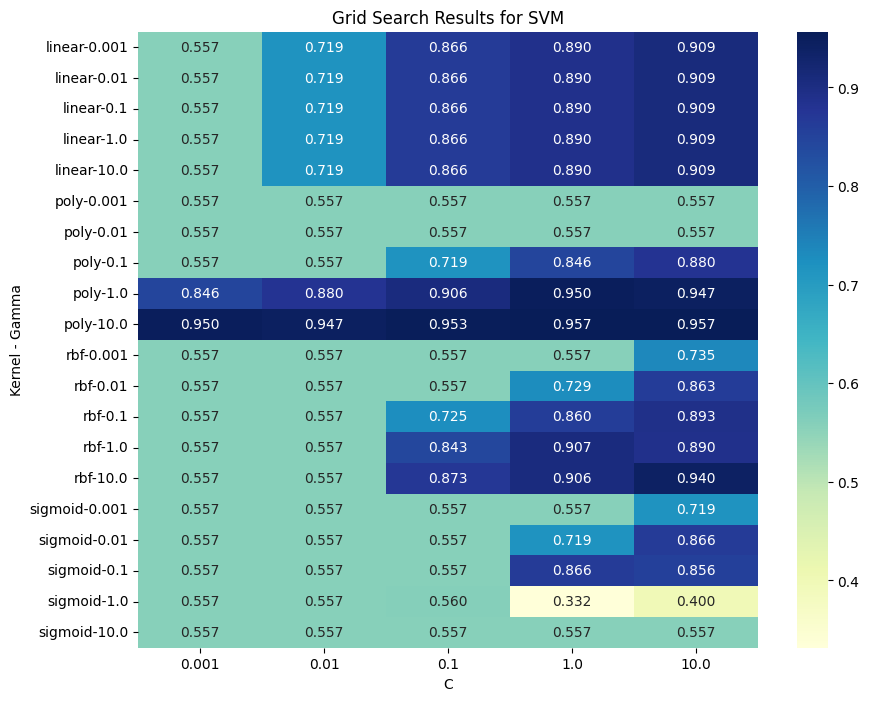

In [250]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = svm_grid_search_with_splits(X, y, test_size=0.1, val_size=0.1)

In [252]:
# Define the models with their respective hyperparameters
svm_model = SVC(C=1, gamma=10, kernel='poly', random_state=123)

# Perform 10-fold cross-validation for SVM
svm_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("RBF SVM Cross-Validated Scores:")
print("SVM Mean Accuracy:", svm_scores.mean())
print("SVM Standard Deviation:", svm_scores.std())

RBF SVM Cross-Validated Scores:
SVM Mean Accuracy: 0.9565517241379309
SVM Standard Deviation: 0.04482110180038647


##### <a id="step44">XGBoost Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (336, 26), y_train_val shape: (336,)
X_test shape: (38, 26), y_test shape: (38,)
X_train shape: (298, 26), y_train shape: (298,)
X_val shape: (38, 26), y_val shape: (38,)
Best Parameters for XGBoost: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0}
Best Score for XGBoost: 0.9398850574712643


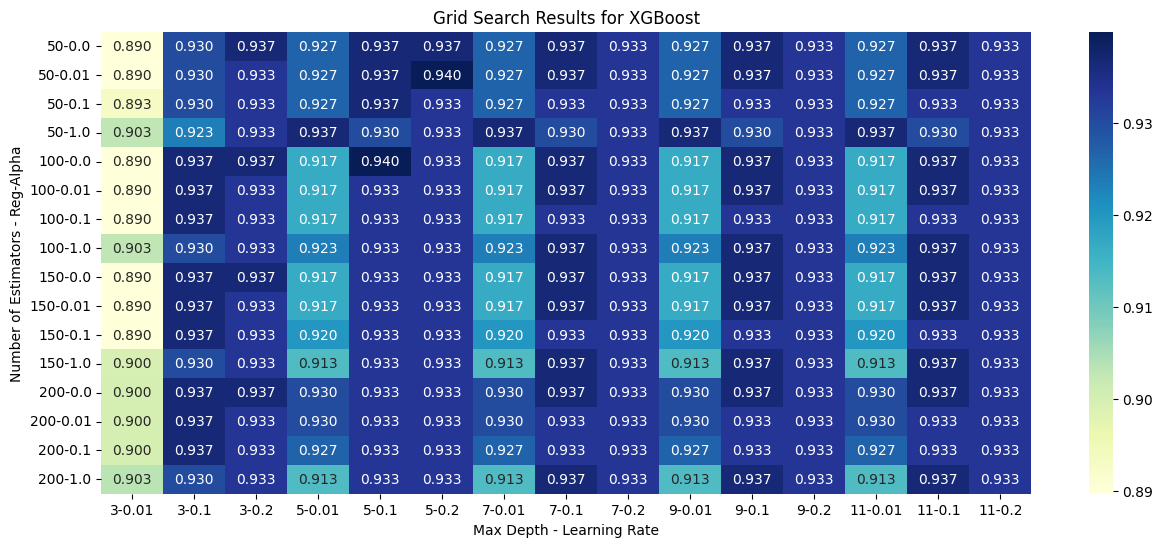

In [255]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = xgb_grid_search_with_splits(X, y, test_size=0.1, val_size=0.1)

In [259]:
# Define the models with their respective hyperparameters
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0, random_state=123)

# Perform 10-fold cross-validation for XGBoost
xgb_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("XGBoost Cross-Validated Scores:")
print("Mean Accuracy:", xgb_scores.mean())
print("Standard Deviation:", xgb_scores.std())

XGBoost Cross-Validated Scores:
Mean Accuracy: 0.9398850574712643
Standard Deviation: 0.04660221470748737


##### <a id="step45">Random Forest Training</a>
<a href="#contents">^ Contents</a>

X_train_val shape: (336, 26), y_train_val shape: (336,)
X_test shape: (38, 26), y_test shape: (38,)
X_train shape: (298, 26), y_train shape: (298,)
X_val shape: (38, 26), y_val shape: (38,)
Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameter for random forest: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best score for random forest: 0.9498850574712643


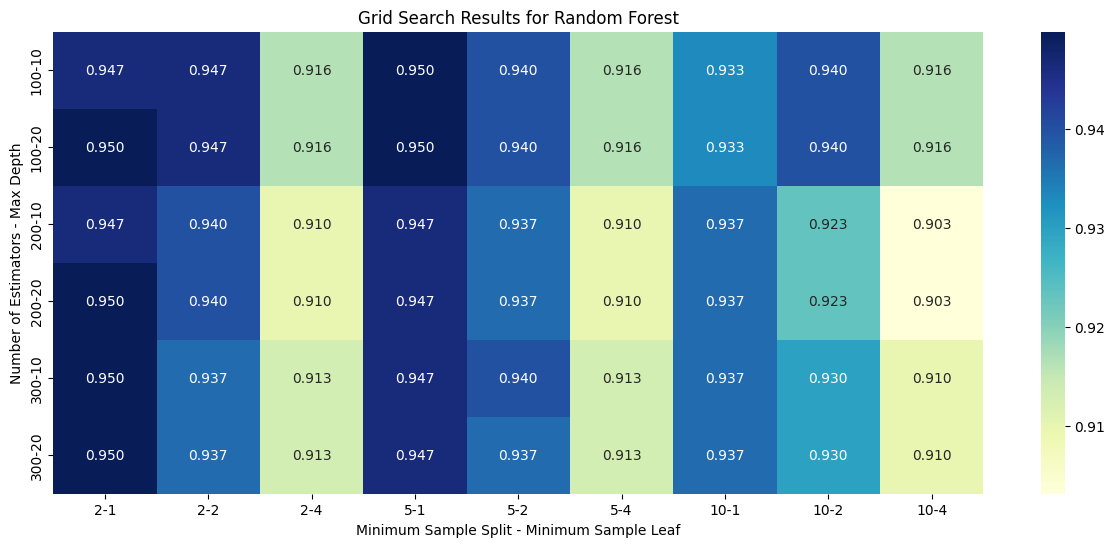

In [261]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = rf_grid_search_with_splits(X, y, test_size=0.1, val_size=0.1)

In [264]:
# Define the models with their respective hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123)

# Perform 10-fold cross-validation for XGBoost
rf_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=10)

# Print mean and standard deviation of cross-validated scores
print("Random Forest Cross-Validated Scores:")
print("Mean Accuracy:", rf_scores.mean())
print("Standard Deviation:", rf_scores.std())

Random Forest Cross-Validated Scores:
Mean Accuracy: 0.9498850574712643
Standard Deviation: 0.04996286109141156


###### <a id="step46">TRAINING RESULTS</a>
<a href="#contents">^ Contents</a>

In [266]:
train_accuracies = [['SVM',  svm_scores.mean(), svm_scores.std()],
                    ['XGBoost',  xgb_scores.mean(), xgb_scores.std()],
                    ['Random Forest',  rf_scores.mean(), rf_scores.std()]]

train_table4 = tabulate(train_accuracies, headers=["Model 4 (80/10/10)", "Training Accuracy", "Training Standard Deviation"], tablefmt="grid", floatfmt=".4f")

print(train_table)
print()
print(train_table2)
print()
print(train_table3)
print()
print(train_table4)

+----------------------+---------------------+-------------------------------+
| Model 1 (50/10/40)   |   Training Accuracy |   Training Standard Deviation |
+======================+=====================+===============================+
| SVM                  |              0.9304 |                        0.0581 |
+----------------------+---------------------+-------------------------------+
| XGBoost              |              0.9520 |                        0.0497 |
+----------------------+---------------------+-------------------------------+
| Random Forest        |              0.9518 |                        0.0498 |
+----------------------+---------------------+-------------------------------+

+----------------------+---------------------+-------------------------------+
| Model 2 (60/10/30)   |   Training Accuracy |   Training Standard Deviation |
+======================+=====================+===============================+
| SVM                  |              0.9464 |     

In model 4, the training accuracies did increase ever so slightly for SVM and Random Forest classifiers, but not by much (0.6-1% increase). The standard deviation stayed about the same between model 3 and 4.

Now let's look at the validation accuracy, precision, recall, and F1 scores of the model 4:

##### <a id="step47">SVM Validation</a>
<a href="#contents">^ Contents</a>

In [268]:
# Define the models with the best hyperparameters
svm_model = SVC(C=1, gamma=10, kernel='poly', random_state=123)

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = svm_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
svm_accuracy = accuracy_score(y_val, y_pred)
svm_precision = precision_score(y_val, y_pred)
svm_recall = recall_score(y_val, y_pred)
svm_f1 = f1_score(y_val, y_pred)

print("SVM Accuracy on the validation set: {:.4f}".format(svm_accuracy))
print("SVM Precision on the validation set: {:.4f}".format(svm_precision))
print("SVM Recall on the validation set: {:.4f}".format(svm_recall))
print("SVM F1 on the validation set: {:.4f}".format(svm_f1))

SVM Accuracy on the validation set: 0.9211
SVM Precision on the validation set: 1.0000
SVM Recall on the validation set: 0.8750
SVM F1 on the validation set: 0.9333


##### <a id="step48">XGBoost Validation</a>
<a href="#contents">^ Contents</a>

In [271]:
# Define the models with the best hyperparameters
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0, random_state=123)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = xgb_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
xgb_accuracy = accuracy_score(y_val, y_pred)
xgb_precision = precision_score(y_val, y_pred)
xgb_recall = recall_score(y_val, y_pred)
xgb_f1 = f1_score(y_val, y_pred)

print("XGBoost Accuracy on the validation set: {:.4f}".format(xgb_accuracy))
print("XGBoost Precision on the validation set: {:.4f}".format(xgb_precision))
print("XGBoost Recall on the validation set: {:.4f}".format(xgb_recall))
print("XGBoost F1 on the validation set: {:.4f}".format(xgb_f1))

XGBoost Accuracy on the validation set: 0.9474
XGBoost Precision on the validation set: 1.0000
XGBoost Recall on the validation set: 0.9167
XGBoost F1 on the validation set: 0.9565


##### <a id="step49">Random Forest Validation</a>
<a href="#contents">^ Contents</a>

In [274]:
# Define the model with the best hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = rf_model.predict(X_val_scaled)

# Get accuracy, precision, recall, and f1 scores
rf_accuracy = accuracy_score(y_val, y_pred)
rf_precision = precision_score(y_val, y_pred)
rf_recall = recall_score(y_val, y_pred)
rf_f1 = f1_score(y_val, y_pred)

print("Random Forest Accuracy on the validation set: {:.4f}".format(rf_accuracy))
print("Random Forest Precision on the validation set: {:.4f}".format(rf_precision))
print("Random Forest Recall on the validation set: {:.4f}".format(rf_recall))
print("Random Forest F1 on the validation set: {:.4f}".format(rf_f1))

Random Forest Accuracy on the validation set: 0.9737
Random Forest Precision on the validation set: 1.0000
Random Forest Recall on the validation set: 0.9583
Random Forest F1 on the validation set: 0.9787


###### <a id="step50">VALIDATION RESULTS</a>
<a href="#contents">^ Contents</a>

In [277]:
validation_accuracies = [['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1],
         ['XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
         ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1]]

validation_table4 = tabulate(validation_accuracies, headers=["Model 4 (80/10/10)", "Validation Accuracy", 'Validation Precision', 'Validation Recall', 'Validation F1'], tablefmt="grid", floatfmt=".4f")

print(validation_table)
print()
print(validation_table2)
print()
print(validation_table3)
print()
print(validation_table4)

+----------------------+-----------------------+------------------------+---------------------+-----------------+
| Model 1 (50/10/40)   |   Validation Accuracy |   Validation Precision |   Validation Recall |   Validation F1 |
+======================+=======================+========================+=====================+=================+
| SVM                  |                0.8947 |                 0.8696 |              0.9524 |          0.9091 |
+----------------------+-----------------------+------------------------+---------------------+-----------------+
| XGBoost              |                0.9211 |                 0.9091 |              0.9524 |          0.9302 |
+----------------------+-----------------------+------------------------+---------------------+-----------------+
| Random Forest        |                0.9474 |                 0.9524 |              0.9524 |          0.9524 |
+----------------------+-----------------------+------------------------+---------------

In model 4, random forest classifier has the same 97.37% accuracy between model 3 and 4 while precision increased from 96% to 100%. Recall and F1 scores has a slight decrease from model 3 to 4. For SVM an XGBoost their accuracy scores switched with each others scores between model 3 to 4. 

Let's test the model and get the accuracy, precision, recall, and F1 scores for the testing data:

##### <a id="step51">SVM Testing</a>
<a href="#contents">^ Contents</a>

In [280]:
# Define the models with the best hyperparameters
svm_model = SVC(C=1, gamma=10, kernel='poly', random_state=123)

# Fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = svm_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

print("SVM Accuracy on the testing set: {:.4f}".format(svm_accuracy))
print("SVM Precision on the testing set: {:.4f}".format(svm_precision))
print("SVM Recall on the testing set: {:.4f}".format(svm_recall))
print("SVM F1 on the testing set: {:.4f}".format(svm_f1))

SVM Accuracy on the testing set: 1.0000
SVM Precision on the testing set: 1.0000
SVM Recall on the testing set: 1.0000
SVM F1 on the testing set: 1.0000


##### <a id="step52">XGBoost Testing</a>
<a href="#contents">^ Contents</a>

In [283]:
# Define the models with the best hyperparameters
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0, random_state=123)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = xgb_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)

print("XGBoost Accuracy on the testing set: {:.4f}".format(xgb_accuracy))
print("XGBoost Precision on the testing set: {:.4f}".format(xgb_precision))
print("XGBoost Recall on the testing set: {:.4f}".format(xgb_recall))
print("XGBoost F1 on the testing set: {:.4f}".format(xgb_f1))

XGBoost Accuracy on the testing set: 1.0000
XGBoost Precision on the testing set: 1.0000
XGBoost Recall on the testing set: 1.0000
XGBoost F1 on the testing set: 1.0000


##### <a id="step53">Random Forest Testing</a>
<a href="#contents">^ Contents</a>

In [286]:
# Define the model with the best hyperparameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict with the validation set
y_pred = rf_model.predict(X_test_scaled)

# Get accuracy, precision, recall, and f1 scores
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

print("Random Forest Accuracy on the testing set: {:.4f}".format(rf_accuracy))
print("Random Forest Precision on the testing set: {:.4f}".format(rf_precision))
print("Random Forest Recall on the testing set: {:.4f}".format(rf_recall))
print("Random Forest F1 on the testing set: {:.4f}".format(rf_f1))

Random Forest Accuracy on the testing set: 1.0000
Random Forest Precision on the testing set: 1.0000
Random Forest Recall on the testing set: 1.0000
Random Forest F1 on the testing set: 1.0000


###### <a id="step54">TESTING RESULTS</a>
<a href="#contents">^ Contents</a>

In [289]:
testing_accuracies = [['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1],
         ['XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
         ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1]]

test_table4 = tabulate(testing_accuracies, headers=["Model 4 (80/10/10)", "Test Accuracy", "Test Precision", "Test Recall", "Test F1"], tablefmt="grid", floatfmt=".4f")

print(test_table)
print()
print(test_table2)
print()
print(test_table3)
print()
print(test_table4)

+----------------------+-----------------+------------------+---------------+-----------+
| Model 1 (50/10/40)   |   Test Accuracy |   Test Precision |   Test Recall |   Test F1 |
+======================+=================+==================+===============+===========+
| SVM                  |          0.9600 |           0.9451 |        0.9885 |    0.9663 |
+----------------------+-----------------+------------------+---------------+-----------+
| XGBoost              |          0.9467 |           0.9759 |        0.9310 |    0.9529 |
+----------------------+-----------------+------------------+---------------+-----------+
| Random Forest        |          0.9600 |           0.9880 |        0.9425 |    0.9647 |
+----------------------+-----------------+------------------+---------------+-----------+

+----------------------+-----------------+------------------+---------------+-----------+
| Model 2 (60/10/30)   |   Test Accuracy |   Test Precision |   Test Recall |   Test F1 |
+========

In model 4 given that all the accuracy, precision, recall, and F1 scores for all three classifiers have perfect 100% scores, it indicates that the 80/10/10 split between the training, validation, and testing datasets overfitted the data.

For the best overall performance of the models, model 3 with 70/10/20 training/validation/testing split achieved the highest accuracy (98.67%) with perfect precision (100%). This is good for situations where the cost of false positives are high. Recall of 97.56% and F1 score of 98.77% for both classifiers are very high as well. 

If there is a priority in recall to reduce the false negatives when the cost of false negatives is high, then the model 2 60/10/30 split with SVM is the best choice since it has a perfect recall of 100%. However, the precision of the SVM classifier (95.52%) is slightly lower than XGBoost and Random Forest classifiers (98.33%).

## <a id="step55">Conclusion</a>
<a href="#contents">^ Contents</a>

For the Kaggle's Sleep Health and Lifestyle dataset, sleep disorders (insomnia and sleep apnea) were predicted using the features: gender, age, occupation, sleep duration, quality of sleep, physical activity level, stress level, BMI category, blood pressure, heart rate, and daily steps. The missing values for the sleep disorders were predicted using random forest imputation. Three supervised learning classifiers (Support Vector Machine, XGBoost, and Random Forest classifiers) were used as predictive models for sleep disorders. GridSearchCV was performed to find the optimal hyperparameters for each classifier. 4 different models with various training/validation/testing splits (50/10/40, 60/10/30, 70/10/20, and 80/10/10) were explored to find the best performing classifier for this dataset.

Model 4 (80/10/10) showed perfect scores across all four performance metrics for the test set. This indicates that this split overfitted the data. Out of the four different splits, XGBoost and Random Forest classifiers from model 3 (70/10/20) achieved the highest accuracy of 98.67% with perfect precision of 100% and recall of 97.56%. If I were to choose one classifier, I would choose the random forest classifier. Even though the random forest classifier had the lowest training accuracy of 94.3% in comparison to SVM's training accuracy of 94.64% and XGBoost's training accuracy of 94.66%, the random forest classifier had the highest validation accuracy, precision, recall, and F1 scores of 97.37%, 96%, 100%, and 97.96% respectively. The difference in training accuracies between the classifiers is very small. 